# Imports

In [1]:
import os
import sys
import pysam
import pickle
import random
import modisco
import warnings
import plotnine
import pybedtools
import numpy as np
import tabix as tb
import pandas as pd
from plotnine import *
from pandas import Series
from decimal import Decimal
from kerasAC.splits import *
from matplotlib import pyplot as plt
from deeplift.dinuc_shuffle import dinuc_shuffle

from dragonn.interpret import * 
from dragonn.vis import *
from dragonn.utils import *

sys.path.insert(0, "/users/soumyak/alzheimers_parkinsons/clusters_gkmsvm")
from viz_preprocess import *
from viz_sequence import *

np.random.seed(1234)
plt.style.use('default')
pd.set_option('display.max_columns', None)

TF-MoDISco is using the TensorFlow backend.
Using TensorFlow backend.


# Quick Links

<ol>
    <li><a href=#effect_table>Effect Alleles Table</a></li>
    <li><a href=#effect_viz>Effect Alleles Visual</a></li>
    <li><a href=#noneffect_table>Non-Effect Alleles Table</a></li>
    <li><a href=#noneffect_viz>Non-Effect Alleles Visual</a></li>
</ol>

# Cluster 16

In [2]:
cluster = '16'

## Prepare Effect and Non-Effect Scores

In [3]:
effect_fasta = '/mnt/lab_data3/soumyak/adpd/fasta_inputs/Cluster'+cluster+'.effect.fasta'
effect_seqs = [x.rstrip() for (i,x) in enumerate(open(effect_fasta)) if i%2==1]
effect_onehot = [np.array(one_hot_encode_along_channel_axis(x)) for x in effect_seqs]

print("Num effect sequences:", len(effect_onehot))

merged_effect_scores = np.zeros(shape=(len(effect_onehot), 1000, 4))

for fold in range(10):
    effect_file = '/mnt/lab_data3/soumyak/adpd/explain_scores/Cluster'+cluster+'/fold'+str(fold)+'.effect.scores.txt'
    effect_scores = get_hyp_scores(effect_file, effect_seqs)
    effect_scores = np.array(effect_scores)
    merged_effect_scores = merged_effect_scores + effect_scores
    
merged_effect_scores = merged_effect_scores / (fold + 1)

#--------------------------------------------------------#

noneffect_fasta = '/mnt/lab_data3/soumyak/adpd/fasta_inputs/Cluster'+cluster+'.noneffect.fasta'
noneffect_seqs = [x.rstrip() for (i,x) in enumerate(open(noneffect_fasta)) if i%2==1]
noneffect_onehot = [np.array(one_hot_encode_along_channel_axis(x)) for x in noneffect_seqs]

print("Num noneffect sequences:", len(noneffect_onehot))

merged_noneffect_scores = np.zeros(shape=(len(noneffect_onehot), 1000, 4))

for fold in range(10):
    noneffect_file = '/mnt/lab_data3/soumyak/adpd/explain_scores/Cluster'+cluster+'/fold'+str(fold)+'.noneffect.scores.txt'
    noneffect_scores = get_hyp_scores(noneffect_file, noneffect_seqs)
    noneffect_scores = np.array(noneffect_scores)
    merged_noneffect_scores = merged_noneffect_scores + noneffect_scores
    
merged_noneffect_scores = merged_noneffect_scores / (fold + 1)

#--------------------------------------------------------#

merged_ism_scores = np.zeros(shape=(len(effect_onehot),))
merged_delta_scores = np.zeros(shape=(len(effect_onehot),))

for fold in range(10):
    ism_scores = np.array([float(i.strip().split('\t')[1]) for i in open('/mnt/lab_data3/soumyak/adpd/ism_scores/Cluster'+cluster+'/fold'+str(fold)+'.ism.scores').readlines()])
    delta_scores = np.array([float(i.strip().split('\t')[1]) for i in open('/mnt/lab_data3/soumyak/adpd/delta_scores/Cluster'+cluster+'/fold'+str(fold)+'.delta.scores').readlines()])
    merged_ism_scores = merged_ism_scores + ism_scores
    merged_delta_scores = merged_delta_scores + delta_scores
        
merged_ism_scores = merged_ism_scores / (fold + 1)
merged_delta_scores = merged_delta_scores / (fold + 1)

Num effect sequences: 312
Num noneffect sequences: 312


## Prepare DataFrame

In [4]:
snps = pd.read_csv('/mnt/lab_data3/soumyak/adpd/snp_lists/Cluster'+cluster+'.overlap.expanded.snps.hg38.bed', sep='\t')
ryan_snps = pd.read_csv('/oak/stanford/groups/akundaje/projects/alzheimers_parkinsons/snps_final/191023_All_GWAS_SNPs_unique.csv', sep='\t')
mike_snps = pd.read_csv('/oak/stanford/groups/akundaje/projects/alzheimers_parkinsons/snps_final/ld_buddies_table_stage3.tsv', sep='\t')
effect_score = []
noneffect_score = []
effect_center = []
noneffect_center = []
effect_ratio = []
noneffect_ratio = []
allele_ratio = []
allele_diff = []
effect_rank = []
noneffect_rank = []
ism_score = []
delta_score = []
idr_peak = []
all_gwas = []
coloc = []
for index,row in snps.iterrows():
    effect_score.append(np.sum(np.array([np.sum(j) for j in merged_effect_scores[index][400:600]])))
    noneffect_score.append(np.sum(np.array([np.sum(j) for j in merged_noneffect_scores[index][400:600]])))
    effect_center.append(np.sum(np.array([max(0, np.sum(j)) for j in merged_effect_scores[index][475:525]])))
    noneffect_center.append(np.sum(np.array([max(0, np.sum(j)) for j in merged_noneffect_scores[index][475:525]])))
    effect_ratio.append(np.sum(np.array([max(0, np.sum(j)) for j in merged_effect_scores[index][475:525]])) / np.sum(np.array([max(0, np.sum(j)) for j in merged_effect_scores[index][400:600]])))
    noneffect_ratio.append(np.sum(np.array([max(0, np.sum(j)) for j in merged_noneffect_scores[index][475:525]])) / np.sum(np.array([max(0, np.sum(j)) for j in merged_noneffect_scores[index][400:600]])))
    allele_ratio.append(effect_center[-1] / (noneffect_center[-1] + 0.00001))
    #allele_diff.append(effect_center[-1] - noneffect_center[-1])
    allele_diff.append(np.sum(np.array([np.sum(j) for j in merged_effect_scores[index][475:525]])) - np.sum(np.array([np.sum(j) for j in merged_noneffect_scores[index][475:525]])))
    effect_rank.append((effect_center[-1] / (noneffect_center[-1] + 0.00001)) * effect_ratio[-1])
    noneffect_rank.append((noneffect_center[-1] / (effect_center[-1] + 0.00001)) * noneffect_ratio[-1])
    idr_peak_overlap = False
    for ind,rw in ryan_snps.loc[ryan_snps['rsid']==row['rsid']].iterrows():
        if rw['Cluster'+cluster+'_overlap'] == 1:
            idr_peak_overlap = True
    idr_peak.append(idr_peak_overlap)
    gwas_list = []
    has_coloc = False
    for ind,rw in mike_snps.loc[mike_snps['rsid']==row['rsid']].iterrows():
        gwas_list.append(rw['source_gwas']+': '+str('%.2E' % Decimal(rw['pvalue'])))
        if rw['has_coloc'] == True:
            has_coloc = True
    all_gwas.append(gwas_list)
    coloc.append(has_coloc)
snps['effect_score'] = effect_score
snps['noneffect_score'] = noneffect_score
snps['effect_center'] = effect_center
snps['noneffect_center'] = noneffect_center
snps['effect_ratio'] = effect_ratio
snps['noneffect_ratio'] = noneffect_ratio
snps['allele_ratio'] = allele_ratio
snps['allele_diff'] = allele_diff
snps['effect_rank'] = effect_rank
snps['noneffect_rank'] = noneffect_rank
snps['ism_score'] = merged_ism_scores
snps['delta_score'] = merged_delta_scores
snps['idr_peak'] = idr_peak
snps['all_gwas'] = all_gwas
snps['coloc'] = coloc
snps.sort_values(by=['allele_ratio'], ascending=True, inplace=True)
snps.drop_duplicates(subset=['rsid'], inplace=True)

## Find Effect Alleles that Break Accessibility <a name='effect_table' />

In [5]:
neg_snps = snps.loc[snps['allele_ratio'] <= 1]
neg_snps.sort_values(by=['noneffect_rank'], ascending=False, inplace=True)
display(neg_snps)

chr      start        end         rsid effect noneffect ref    alt  \
215  chr19   45326535   45326536     rs344791      C         G   G      C   
72   chr17   45848599   45848600   rs62054817      G         A   G      A   
153  chr19   18438073   18438074    rs2303696    NAN       NAN   T      C   
163  chr19   44724477   44724478    rs7254776      C         T   T    C,G   
161  chr19   44644418   44644419   rs10426401      T         G   T      G   
245   chr3   49007333   49007334    rs6781790      T         C   C      T   
251   chr3   52288193   52288194  rs146664705      G         C   C    A,G   
256   chr3   52557247   52557248  rs151215721      G         A   G      A   
101  chr17   45947195   45947196   rs62062785      T         G   G    A,T   
285   chr6   27772520   27772521     rs760587      C         A   C      A   
74   chr17   45848782   45848783   rs62054819      G         A   A      G   
140  chr17   75035094   75035095    rs7210163      A         G   G      A   
1     chr1  171688802  171688803   rs12119553      T         C   C    A,T   
277   chr5  102971887  102971888    rs6881225      T         C   T      C   
173  chr19   44846144   44846145    rs3810143      C         T   T    C,G   
262   chr4     872934     872935   rs62297061    NAN       NAN   C      T   
157  chr19   18506340   18506341    rs8109573      T         G   G      T   
258   chr3  122416407  122416408   rs55911744      T         G   T      G   
93   chr17   45924695   45924696   rs17564591      C         A   A      C   
84   chr17   45894418   45894419   rs11575895      G         A   A      G   
281   chr5  103120549  103120550      rs26523      T         C   C      T   
216   chr2   95076707   95076708    rs3105100      C         A   A      C   
86   chr17   45894775   45894776   rs11575896      G         A   G      A   
32   chr14   67517150   67517151    rs7161368      T         C   C    G,T   
46   chr16   31033575   31033576   rs12445650      G         A   G      A   
162  chr19   44718494   44718495   rs79638902      T         C   T      C   
222   chr2  101762072  101762073   rs13019379      C         A   A    C,T   
97   chr17   45941121   45941122  17_45941122      T         C   .      .   
144  chr17   78432471   78432472    rs7212019      G         A   G      A   
229   chr2  127106969  127106970   rs11554586      A         G   G      A   
..     ...        ...        ...          ...    ...       ...  ..    ...   
126  chr17   46107061   46107062  rs111295615      T         C   T    A,C   
83   chr17   45894237   45894238   rs62056778      G         C   C      G   
279   chr5  103026278  103026279    rs7717343      T         C   T      C   
143  chr17   78432411   78432412   rs11077365      C         A   C      A   
71   chr17   45801941   45801942   rs80184151      G         A   A      G   
181  chr19   44905578   44905579     rs405509      T         G   T      G   
306   chr8   22623005   22623006   rs11780207      G         A   G      A   
61   chr17    4909107    4909108   rs16954243      T         A   A      T   
63   chr17   45425633   45425634  17_45425634      G         A   .      .   
205  chr19   44989300   44989301   rs11669173      G         A   G      A   
175  chr19   44865945   44865946  rs112422902      A         G   G      A   
264   chr4     973550     973551  rs113075206      G         C   C      G   
105  chr17   45949128   45949129   rs74531363      G         A   A    G,T   
80   chr17   45858521   45858522   rs55996632      T         C   C      T   
288   chr7   23086302   23086303    rs9691762      C         G   G    A,C   
235   chr2  127107527  127107528  2_127107528    NAN       NAN   .      .   
220   chr2   95346089   95346090    rs6750542      G         C   C      G   
120  chr17   46002672   46002673   rs62064663      T         G   T      G   
280   chr5  103026299  103026300   rs55896090      G         C   G      C   
270   chr4   18021068   18021069    rs7659195      T         C   T      C   
239

## Visualize Top Effect Alleles <a name='effect_viz' />

RSID: rs344791   ||    chr19 : 45326535 - 45326536   ||    Locus: 215   ||    IDR Peak: True

GWAS:
Alzheimers_Jansen_2018 		  1.22E-04

Coloc:  True

Noneffect Allele : G   ||   Explain Score : 0.3876   ||   Center / 200bp : 0.4428
Noneffect Sequence : CTCAAGACCGCCTCCACTGT


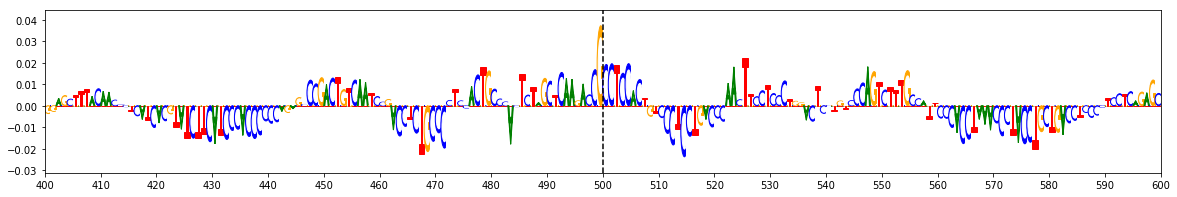

Effect Allele : C   ||   Explain Score : 0.1461   ||   Center / 200bp : 0.2324
Effect Sequence : CTCAAGACCCCCTCCACTGT


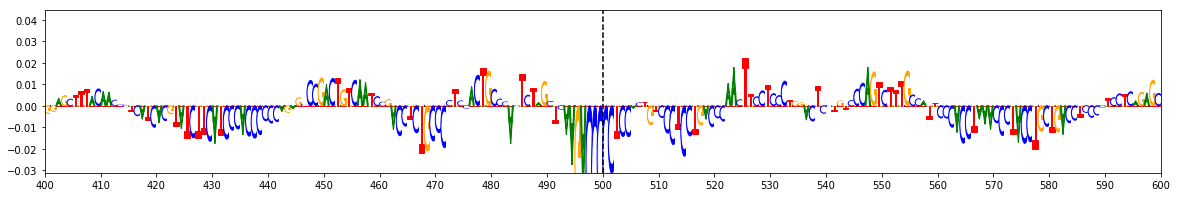

Allele Ratio : 0.3769   ||   Allele Difference : -0.6719  ||  ISM Score : -1.0698  ||  deltaSVM Score : -6.1478


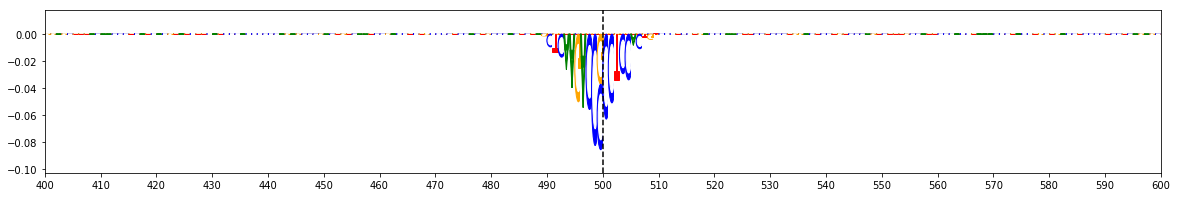


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs62054817   ||    chr17 : 45848599 - 45848600   ||    Locus: 72   ||    IDR Peak: True

GWAS:
23andme_PD_hg38 		  1.14E-22

Coloc:  True

Noneffect Allele : A   ||   Explain Score : 1.8042   ||   Center / 200bp : 0.7571
Noneffect Sequence : ATCTTCCCCAGTAGAGGGCC


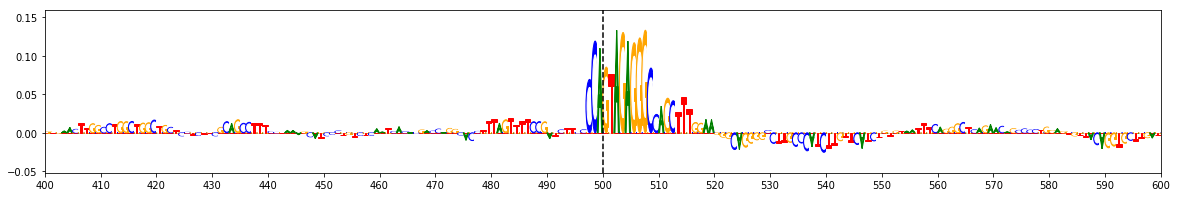

Effect Allele : G   ||   Explain Score : 1.2542   ||   Center / 200bp : 0.6842
Effect Sequence : ATCTTCCCCGGTAGAGGGCC


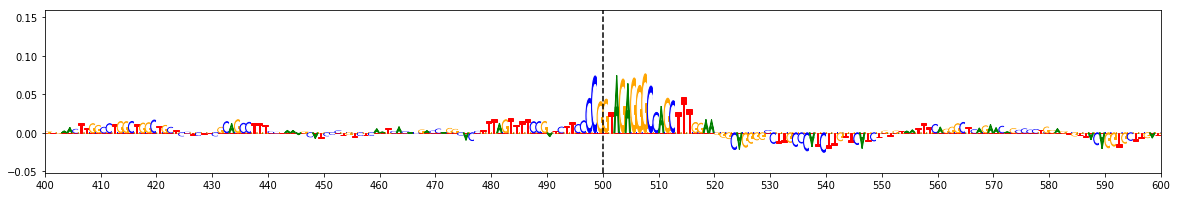

Allele Ratio : 0.6951   ||   Allele Difference : -0.5436  ||  ISM Score : -0.8565  ||  deltaSVM Score : -4.9212


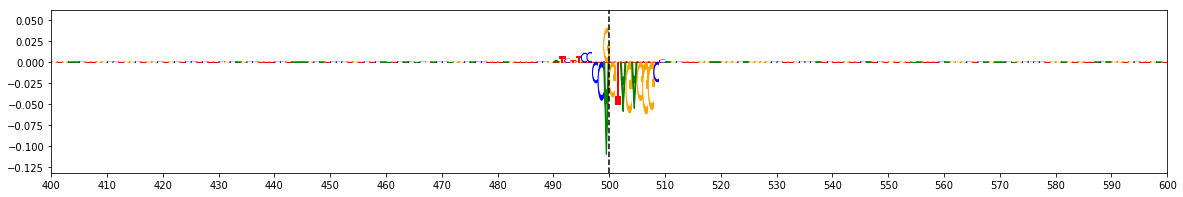


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs2303696   ||    chr19 : 18438073 - 18438074   ||    Locus: 153   ||    IDR Peak: False

GWAS:
Alzheimers_Jansen_2018 		  8.40E-01
Alzheimers_Kunkle_2019 		  1.89E-05
Alzheimers_Lambert_2013 	  NAN

Coloc:  True

Noneffect Allele : NAN   ||   Explain Score : 0.7467   ||   Center / 200bp : 0.4029
Noneffect Sequence : GGCCGTCCCCGCCCCGAACC


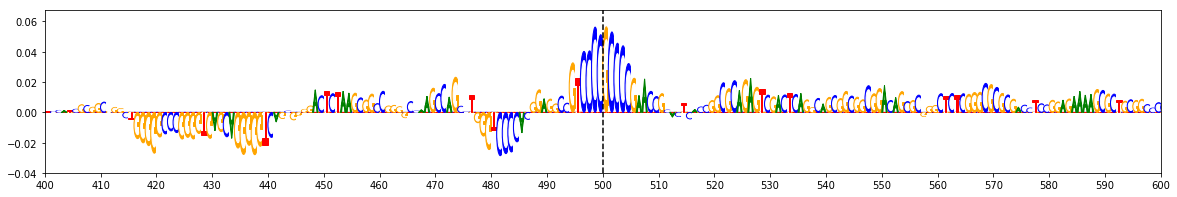

Effect Allele : NAN   ||   Explain Score : 0.3091   ||   Center / 200bp : 0.2176
Effect Sequence : GGCCGTCCCTGCCCCGAACC


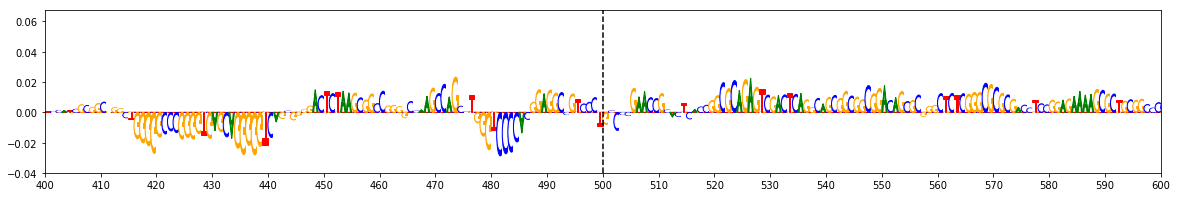

Allele Ratio : 0.414   ||   Allele Difference : -0.4717  ||  ISM Score : -0.7578  ||  deltaSVM Score : -4.2839


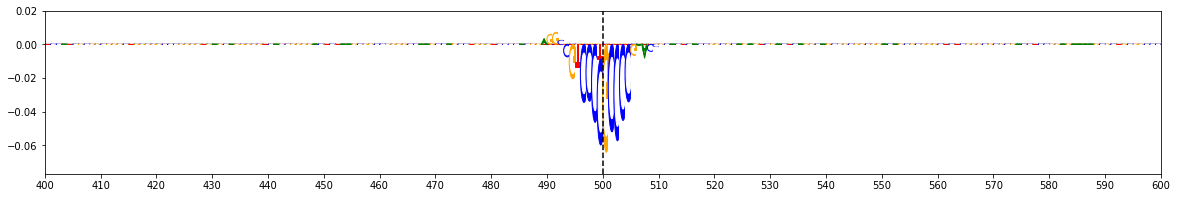


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs7254776   ||    chr19 : 44724477 - 44724478   ||    Locus: 163   ||    IDR Peak: True

GWAS:
Alzheimers_Jansen_2018 		  1.55E-23
Alzheimers_Kunkle_2019 		  2.46E-19
Alzheimers_Lambert_2013 	  4.60E-22

Coloc:  True

Noneffect Allele : T   ||   Explain Score : 0.4613   ||   Center / 200bp : 0.5707
Noneffect Sequence : AATTAGAACTGCATTGTCTC


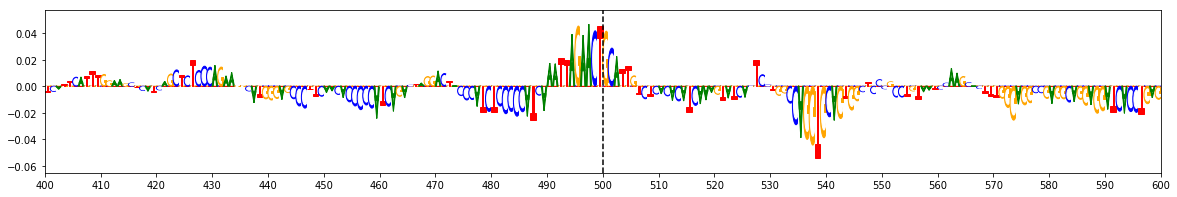

Effect Allele : C   ||   Explain Score : 0.2864   ||   Center / 200bp : 0.4521
Effect Sequence : AATTAGAACCGCATTGTCTC


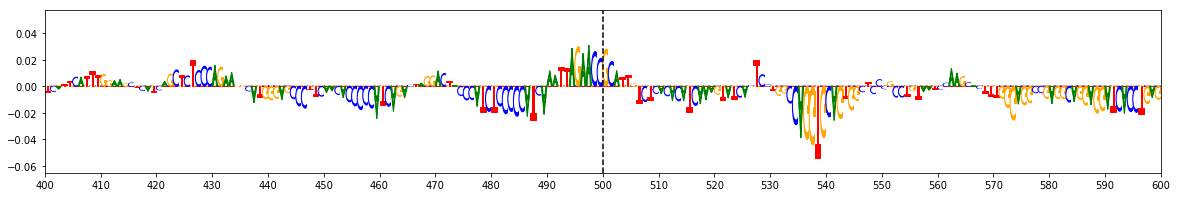

Allele Ratio : 0.6208   ||   Allele Difference : -0.1889  ||  ISM Score : -0.2978  ||  deltaSVM Score : -1.745


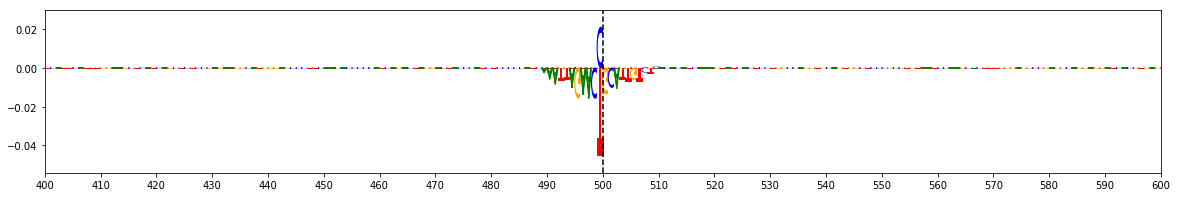


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs10426401   ||    chr19 : 44644418 - 44644419   ||    Locus: 161   ||    IDR Peak: True

GWAS:
Alzheimers_Jansen_2018 		  4.63E-14
Alzheimers_Kunkle_2019 		  5.66E-11
Alzheimers_Lambert_2013 	  2.79E-09

Coloc:  True

Noneffect Allele : G   ||   Explain Score : 1.1476   ||   Center / 200bp : 0.6072
Noneffect Sequence : CAACACGGGGCGGGCACAAG


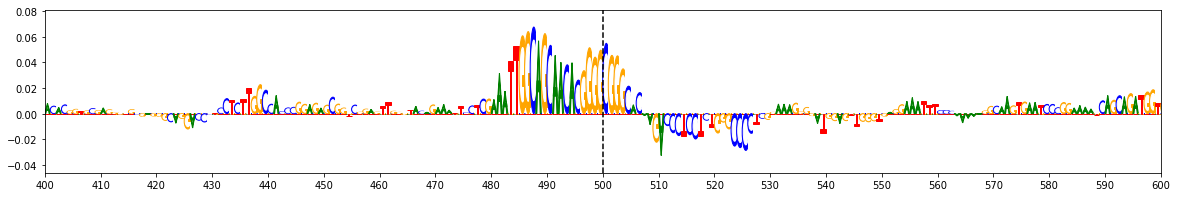

Effect Allele : T   ||   Explain Score : 0.7945   ||   Center / 200bp : 0.5165
Effect Sequence : CAACACGGGTCGGGCACAAG


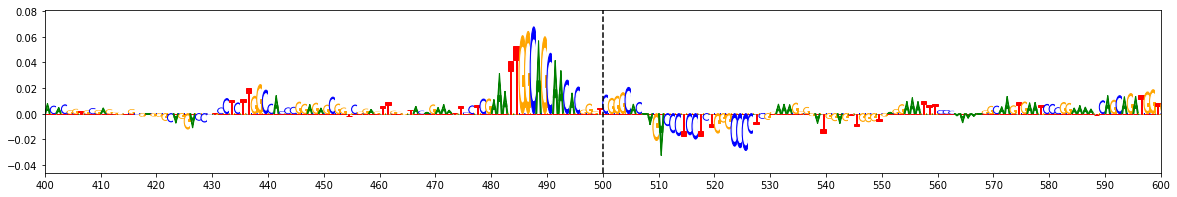

Allele Ratio : 0.6923   ||   Allele Difference : -0.3517  ||  ISM Score : -0.5626  ||  deltaSVM Score : -3.2139


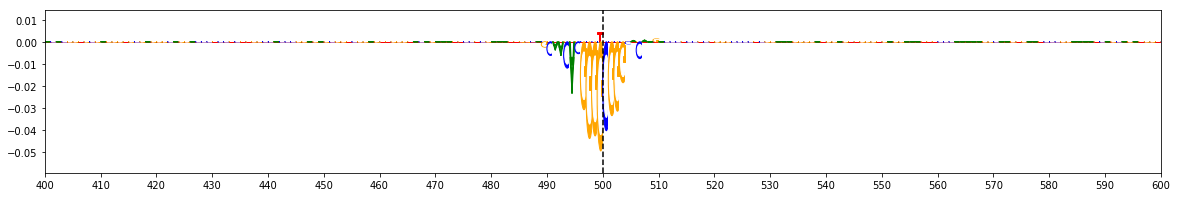


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs6781790   ||    chr3 : 49007333 - 49007334   ||    Locus: 245   ||    IDR Peak: True

GWAS:
Chang_23andMe_Parkinsons 	  2.35E-03
Nalls_23andMe 		  2.35E-03

Coloc:  False

Noneffect Allele : C   ||   Explain Score : 1.0148   ||   Center / 200bp : 0.3689
Noneffect Sequence : AGCTGAGGGCGCTGTTGATG


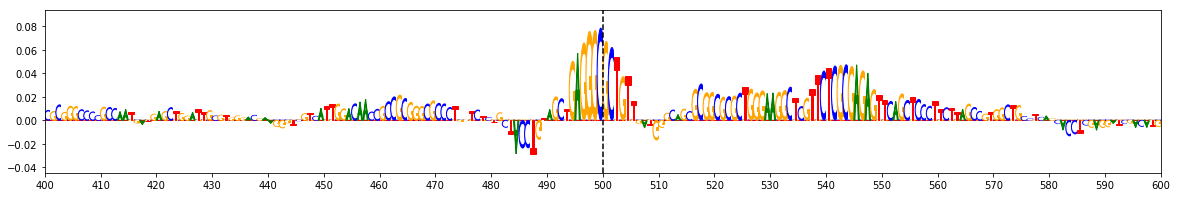

Effect Allele : T   ||   Explain Score : 0.4386   ||   Center / 200bp : 0.2015
Effect Sequence : AGCTGAGGGTGCTGTTGATG


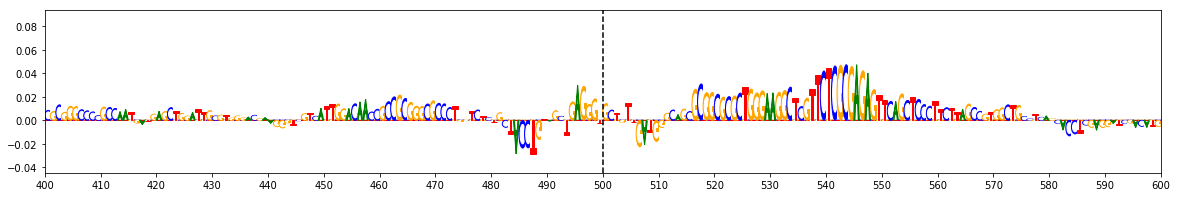

Allele Ratio : 0.4322   ||   Allele Difference : -0.6369  ||  ISM Score : -1.003  ||  deltaSVM Score : -5.8157


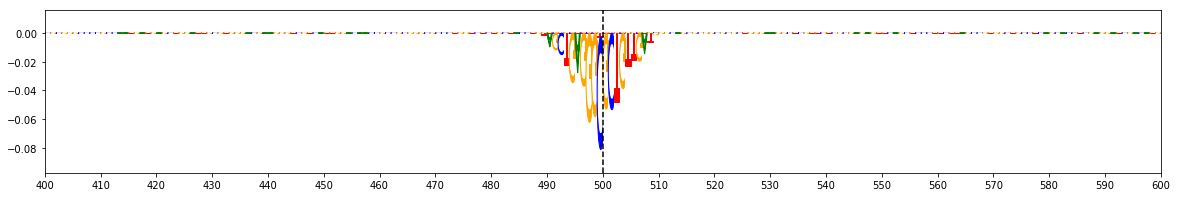


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs146664705   ||    chr3 : 52288193 - 52288194   ||    Locus: 251   ||    IDR Peak: True

GWAS:
Chang_23andMe_Parkinsons 	  1.04E-03

Coloc:  False

Noneffect Allele : C   ||   Explain Score : 1.0109   ||   Center / 200bp : 0.6521
Noneffect Sequence : AGGACTTAGCAAATAAAAAT


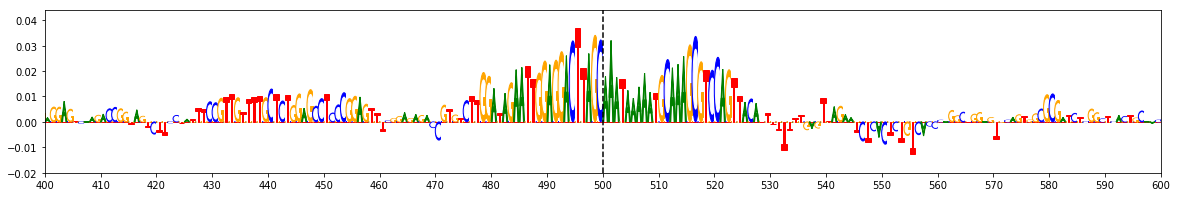

Effect Allele : G   ||   Explain Score : 0.7828   ||   Center / 200bp : 0.5921
Effect Sequence : AGGACTTAGGAAATAAAAAT


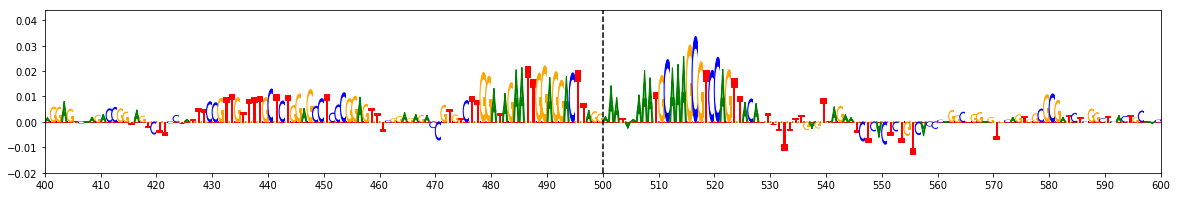

Allele Ratio : 0.7743   ||   Allele Difference : -0.2306  ||  ISM Score : -0.3598  ||  deltaSVM Score : -2.0534


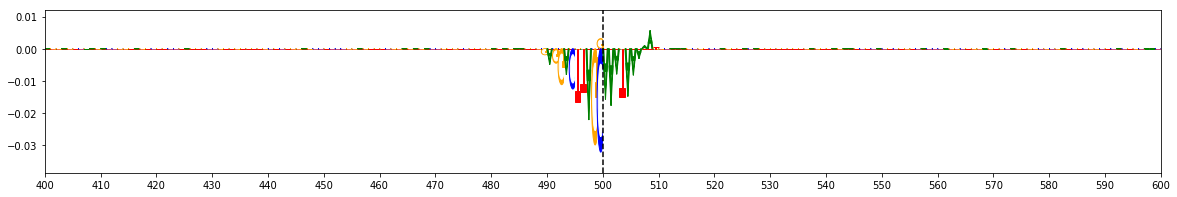


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs151215721   ||    chr3 : 52557247 - 52557248   ||    Locus: 256   ||    IDR Peak: False

GWAS:
Chang_23andMe_Parkinsons 	  1.42E-03

Coloc:  False

Noneffect Allele : A   ||   Explain Score : 1.117   ||   Center / 200bp : 0.6048
Noneffect Sequence : GAGTTCAGCAACAGTGCATT


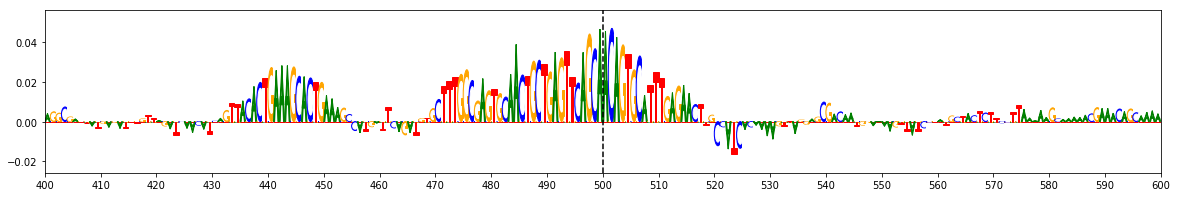

Effect Allele : G   ||   Explain Score : 0.8299   ||   Center / 200bp : 0.5321
Effect Sequence : GAGTTCAGCGACAGTGCATT


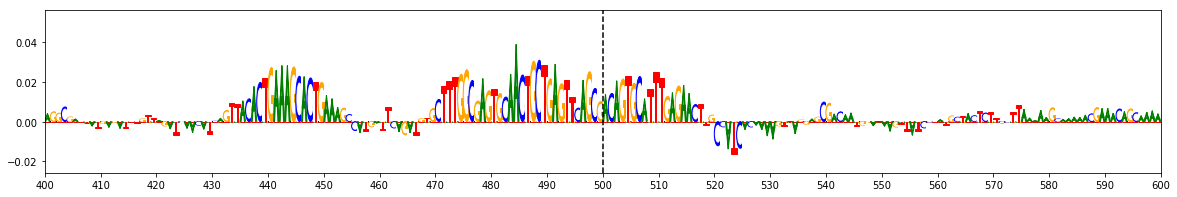

Allele Ratio : 0.743   ||   Allele Difference : -0.2871  ||  ISM Score : -0.4462  ||  deltaSVM Score : -2.6013


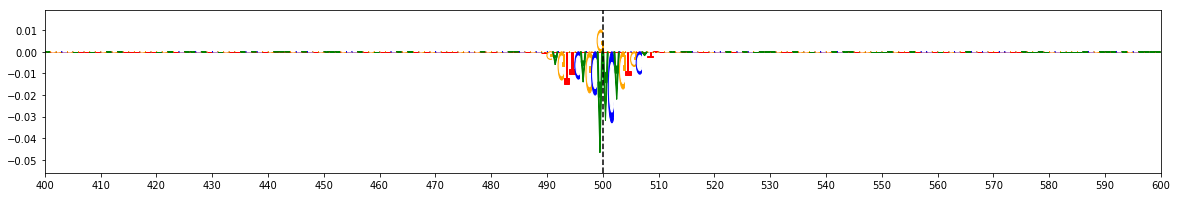


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs62062785   ||    chr17 : 45947195 - 45947196   ||    Locus: 101   ||    IDR Peak: True

GWAS:
23andme_PD_hg38 		  3.33E-22

Coloc:  True

Noneffect Allele : G   ||   Explain Score : 1.1654   ||   Center / 200bp : 0.492
Noneffect Sequence : CTCCCAGTGGCTGCCTGTGT


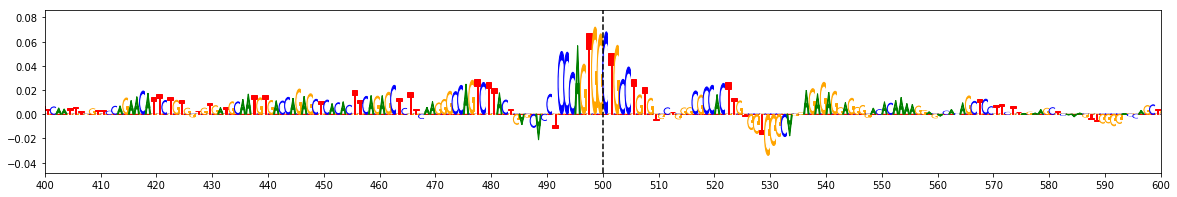

Effect Allele : T   ||   Explain Score : 0.732   ||   Center / 200bp : 0.3783
Effect Sequence : CTCCCAGTGTCTGCCTGTGT


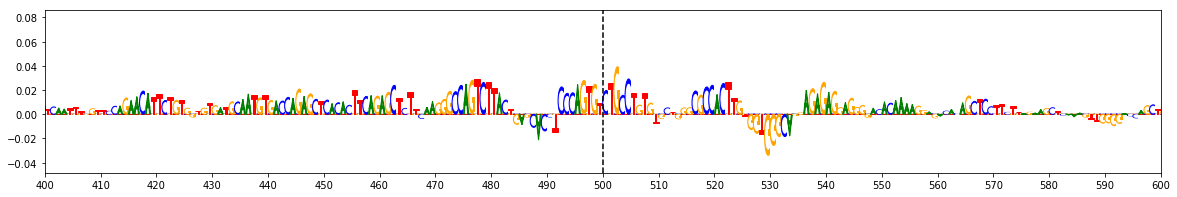

Allele Ratio : 0.6281   ||   Allele Difference : -0.4502  ||  ISM Score : -0.7046  ||  deltaSVM Score : -4.1266


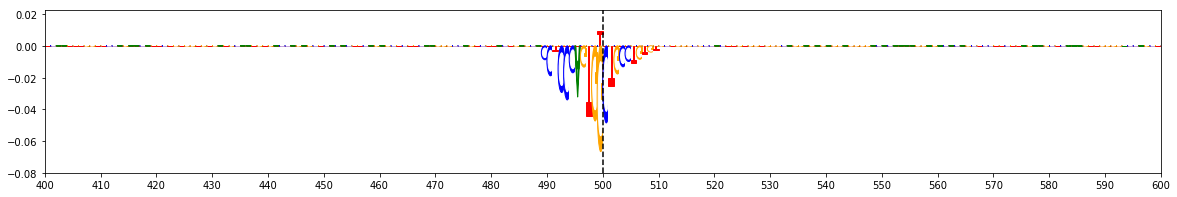


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs760587   ||    chr6 : 27772520 - 27772521   ||    Locus: 285   ||    IDR Peak: True

GWAS:
Nalls_23andMe 		  6.44E-06

Coloc:  False

Noneffect Allele : A   ||   Explain Score : 0.8514   ||   Center / 200bp : 0.461
Noneffect Sequence : GAGCAGCAAACAAAGGCTAA


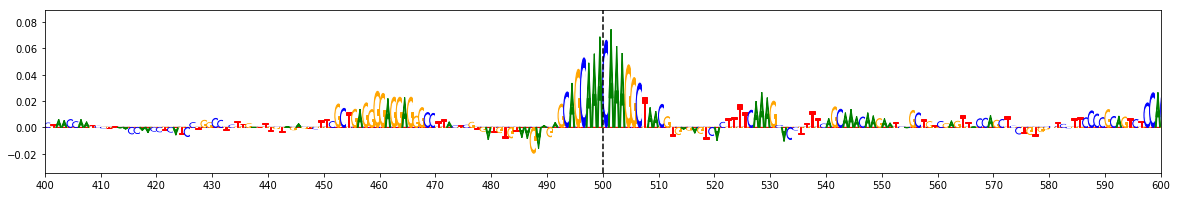

Effect Allele : C   ||   Explain Score : 0.5189   ||   Center / 200bp : 0.3418
Effect Sequence : GAGCAGCAACCAAAGGCTAA


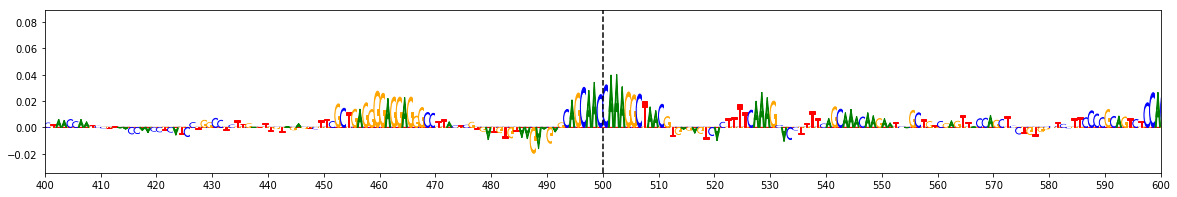

Allele Ratio : 0.6094   ||   Allele Difference : -0.343  ||  ISM Score : -0.5387  ||  deltaSVM Score : -3.0907


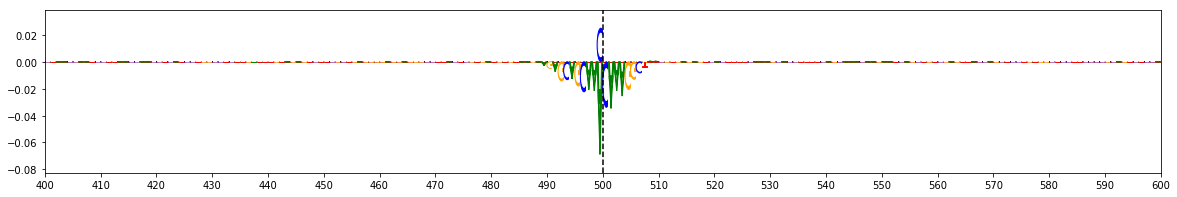


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs62054819   ||    chr17 : 45848782 - 45848783   ||    Locus: 74   ||    IDR Peak: True

GWAS:
23andme_PD_hg38 		  1.71E-22

Coloc:  True

Noneffect Allele : A   ||   Explain Score : 0.7255   ||   Center / 200bp : 0.4835
Noneffect Sequence : AGAGGAGGGAATGCTATGAG


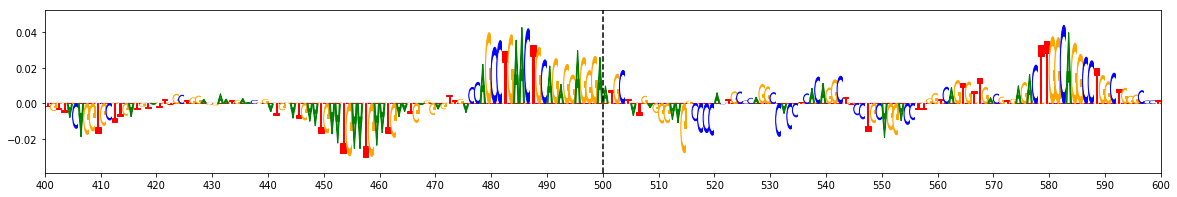

Effect Allele : G   ||   Explain Score : 0.4744   ||   Center / 200bp : 0.3793
Effect Sequence : AGAGGAGGGGATGCTATGAG


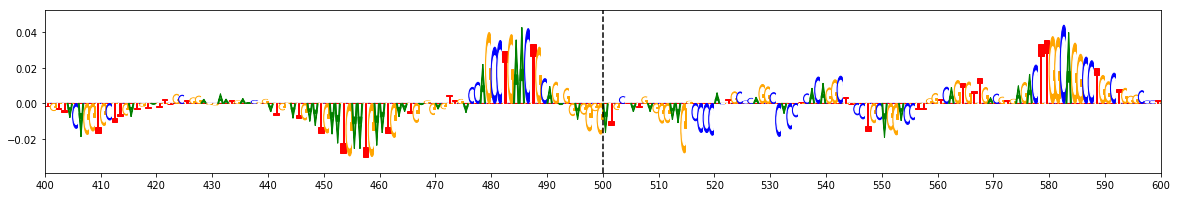

Allele Ratio : 0.6539   ||   Allele Difference : -0.3377  ||  ISM Score : -0.5757  ||  deltaSVM Score : -3.3681


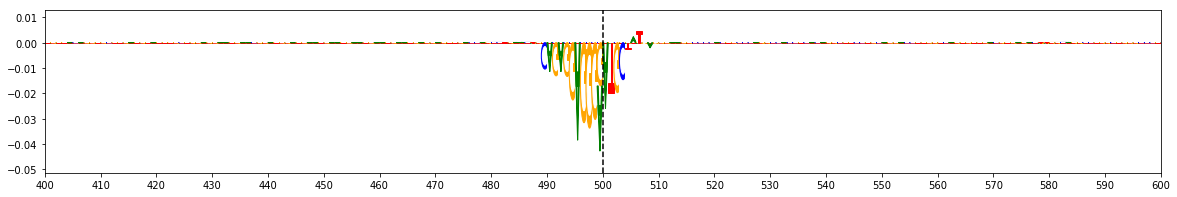


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs7210163   ||    chr17 : 75035094 - 75035095   ||    Locus: 140   ||    IDR Peak: True

GWAS:
Alzheimers_Kunkle_2019 		  1.08E-05
Alzheimers_Lambert_2013 	  1.54E-04

Coloc:  True

Noneffect Allele : G   ||   Explain Score : 0.9456   ||   Center / 200bp : 0.4988
Noneffect Sequence : CCTCTCTAGGAGGTAGCTGC


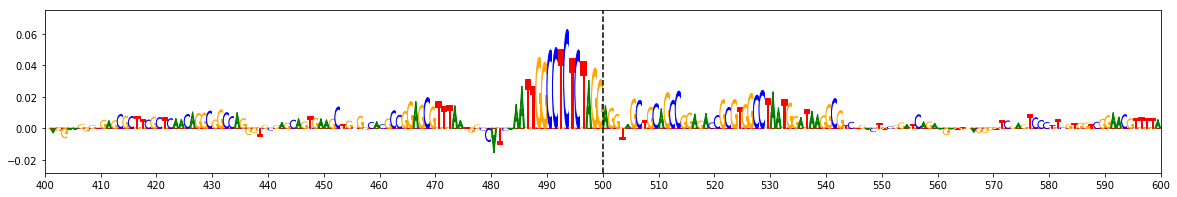

Effect Allele : A   ||   Explain Score : 0.6476   ||   Center / 200bp : 0.4052
Effect Sequence : CCTCTCTAGAAGGTAGCTGC


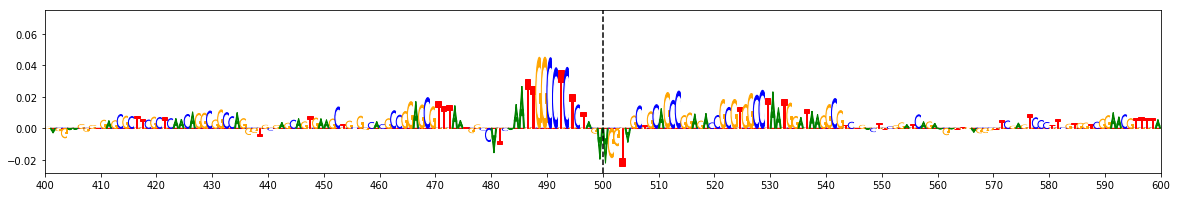

Allele Ratio : 0.6849   ||   Allele Difference : -0.3986  ||  ISM Score : -0.6299  ||  deltaSVM Score : -3.6433


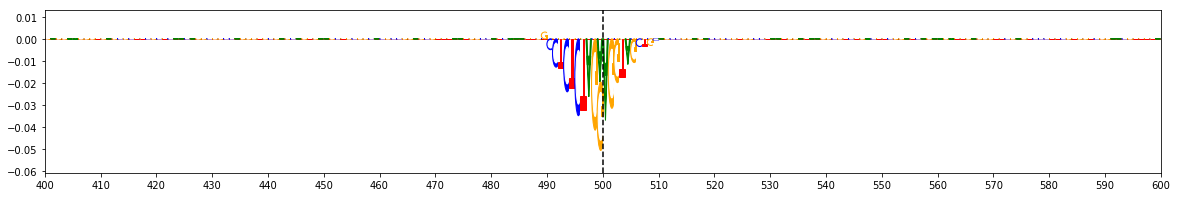


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs12119553   ||    chr1 : 171688802 - 171688803   ||    Locus: 1   ||    IDR Peak: False

GWAS:
Nalls_23andMe 		  1.18E-01

Coloc:  False

Noneffect Allele : C   ||   Explain Score : 0.3829   ||   Center / 200bp : 0.6364
Noneffect Sequence : TTGTACACACGCATCTCTTT


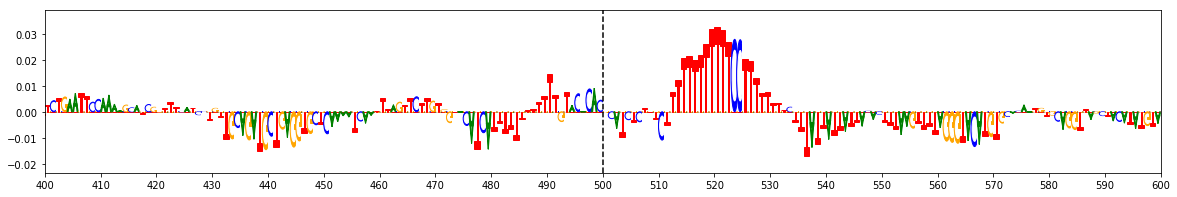

Effect Allele : T   ||   Explain Score : 0.3354   ||   Center / 200bp : 0.6059
Effect Sequence : TTGTACACATGCATCTCTTT


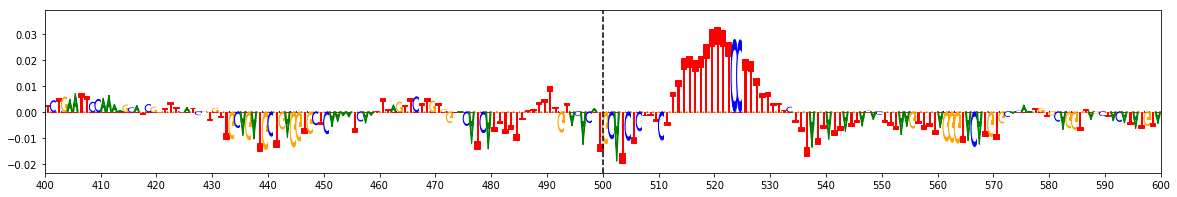

Allele Ratio : 0.876   ||   Allele Difference : -0.1558  ||  ISM Score : -0.2208  ||  deltaSVM Score : -1.7651


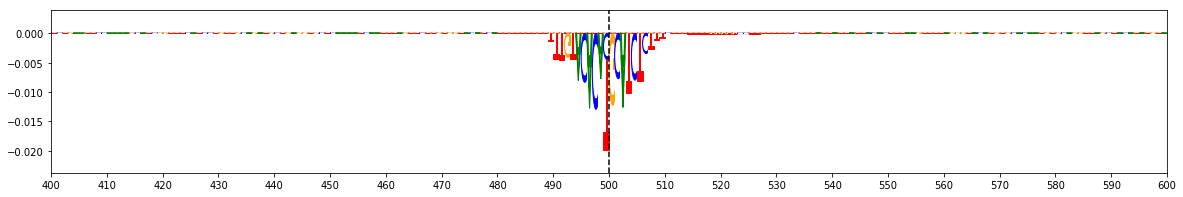


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs6881225   ||    chr5 : 102971887 - 102971888   ||    Locus: 277   ||    IDR Peak: True

GWAS:
Nalls_23andMe 		  1.13E-03

Coloc:  False

Noneffect Allele : C   ||   Explain Score : 2.3135   ||   Center / 200bp : 0.6647
Noneffect Sequence : TGTAAGAGACAGCCATCTAG


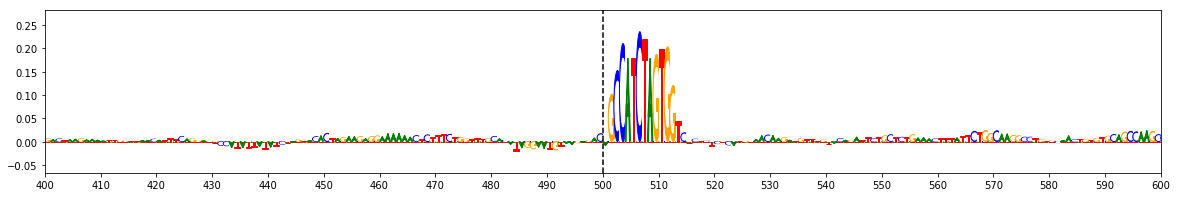

Effect Allele : T   ||   Explain Score : 2.119   ||   Center / 200bp : 0.6451
Effect Sequence : TGTAAGAGATAGCCATCTAG


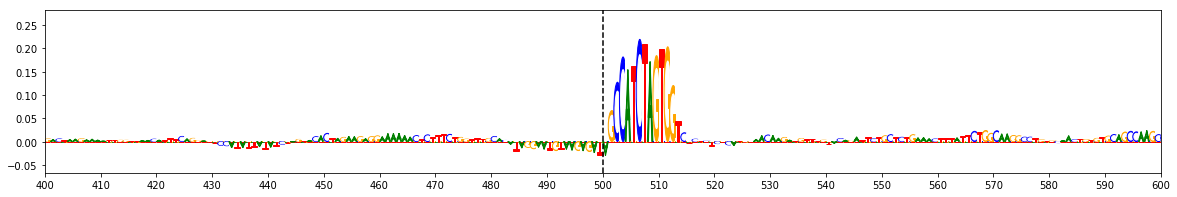

Allele Ratio : 0.9159   ||   Allele Difference : -0.3609  ||  ISM Score : -0.566  ||  deltaSVM Score : -3.2212


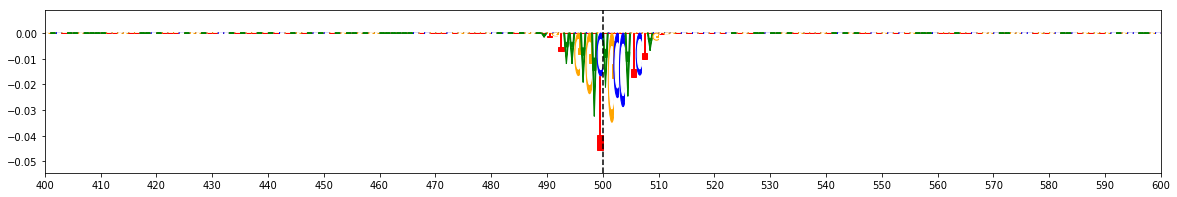


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs3810143   ||    chr19 : 44846144 - 44846145   ||    Locus: 173   ||    IDR Peak: True

GWAS:
Alzheimers_Jansen_2018 		  5.98E-50
Alzheimers_Kunkle_2019 		  1.26E-38
Alzheimers_Lambert_2013 	  4.67E-32

Coloc:  True

Noneffect Allele : T   ||   Explain Score : 1.0065   ||   Center / 200bp : 0.3123
Noneffect Sequence : AGAATTCTTTGGCAGGGGCG


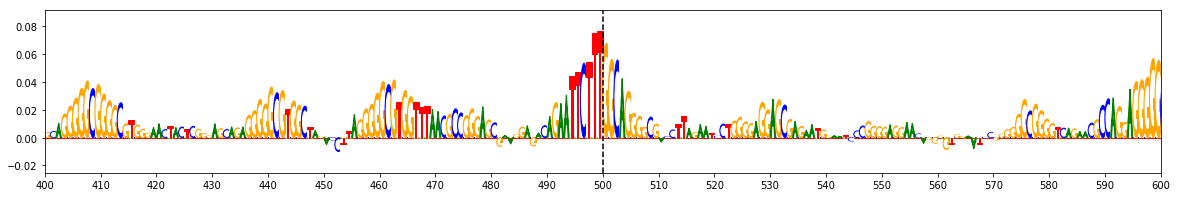

Effect Allele : C   ||   Explain Score : 0.4405   ||   Center / 200bp : 0.1657
Effect Sequence : AGAATTCTTCGGCAGGGGCG


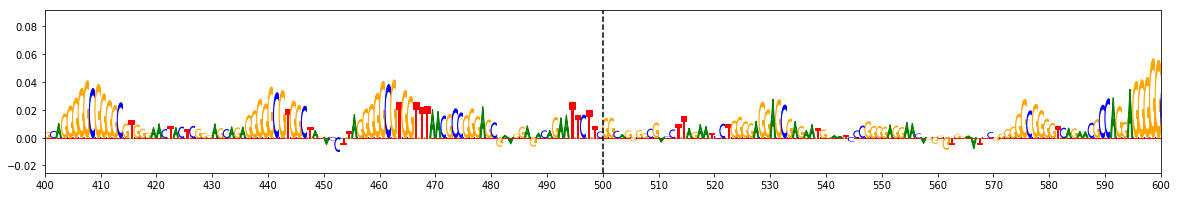

Allele Ratio : 0.4377   ||   Allele Difference : -0.5682  ||  ISM Score : -0.9262  ||  deltaSVM Score : -5.3443


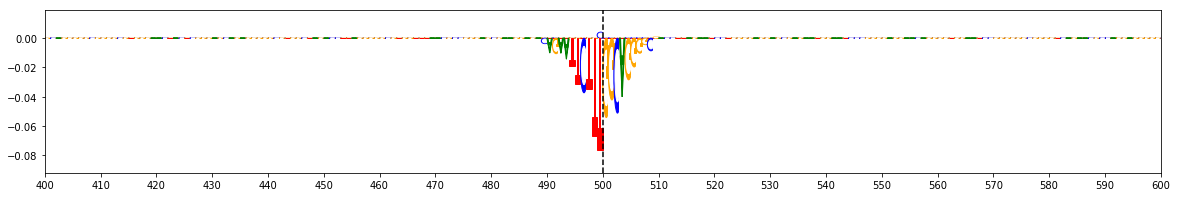


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs62297061   ||    chr4 : 872934 - 872935   ||    Locus: 262   ||    IDR Peak: True

GWAS:
Parkinsons_Pankratz_2012 	  NAN

Coloc:  True

Noneffect Allele : NAN   ||   Explain Score : 0.5843   ||   Center / 200bp : 0.3496
Noneffect Sequence : CAGGCACGGCGCAGGCTCAC


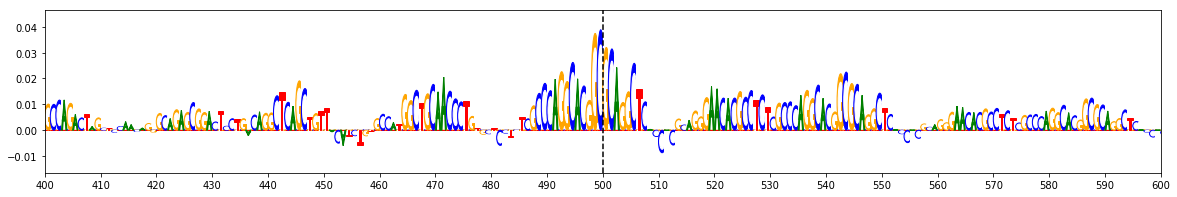

Effect Allele : NAN   ||   Explain Score : 0.2891   ||   Center / 200bp : 0.2023
Effect Sequence : CAGGCACGGTGCAGGCTCAC


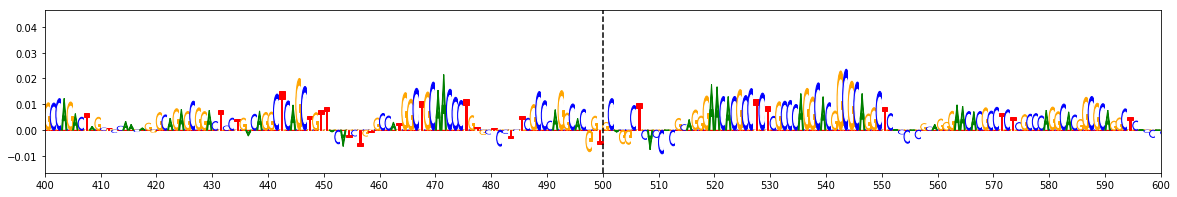

Allele Ratio : 0.4947   ||   Allele Difference : -0.333  ||  ISM Score : -0.756  ||  deltaSVM Score : -4.4008


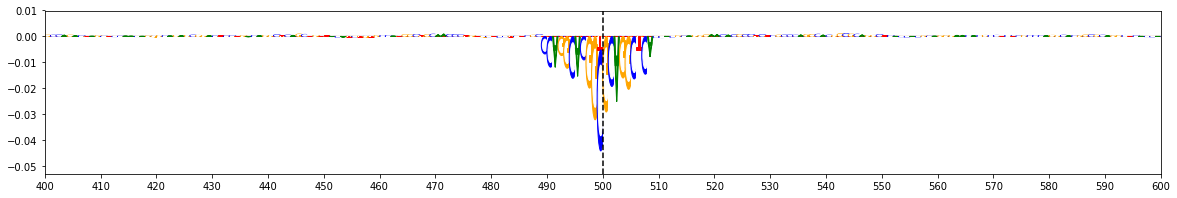


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs8109573   ||    chr19 : 18506340 - 18506341   ||    Locus: 157   ||    IDR Peak: False

GWAS:
Alzheimers_Jansen_2018 		  1.13E-01
Alzheimers_Kunkle_2019 		  8.71E-05
Alzheimers_Lambert_2013 	  6.88E-05

Coloc:  True

Noneffect Allele : G   ||   Explain Score : 0.9488   ||   Center / 200bp : 0.5743
Noneffect Sequence : GGACACCCGGGCTGCTTCAG


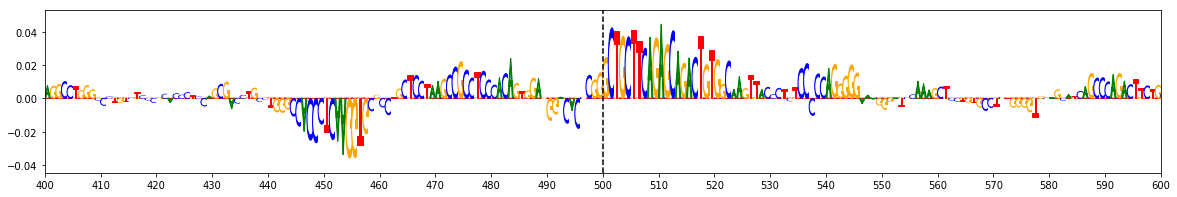

Effect Allele : T   ||   Explain Score : 0.7729   ||   Center / 200bp : 0.5235
Effect Sequence : GGACACCCGTGCTGCTTCAG


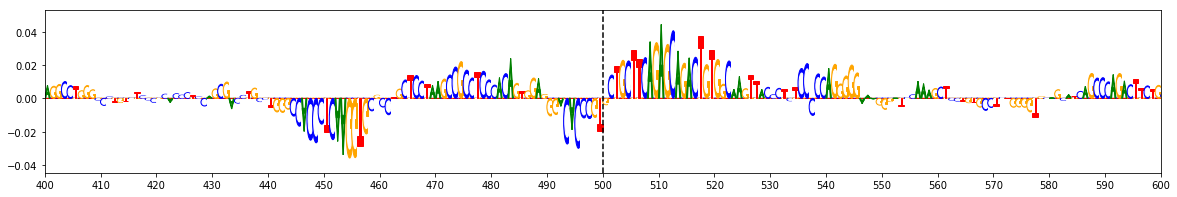

Allele Ratio : 0.8146   ||   Allele Difference : -0.2727  ||  ISM Score : -0.4316  ||  deltaSVM Score : -2.4672


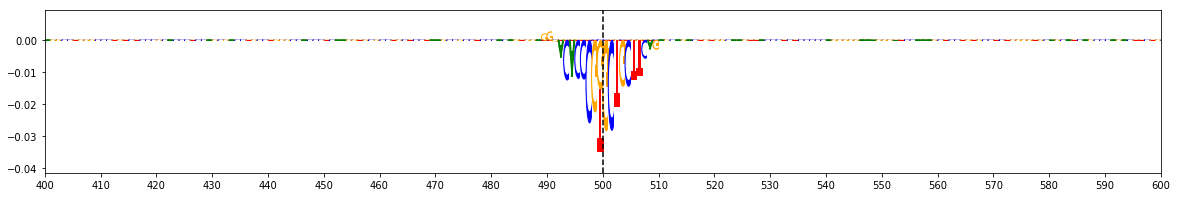


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs55911744   ||    chr3 : 122416407 - 122416408   ||    Locus: 258   ||    IDR Peak: True

GWAS:
Nalls_23andMe 		  4.99E-04

Coloc:  False

Noneffect Allele : G   ||   Explain Score : 0.9004   ||   Center / 200bp : 0.5279
Noneffect Sequence : GCCCACACCGGACGCGTAAG


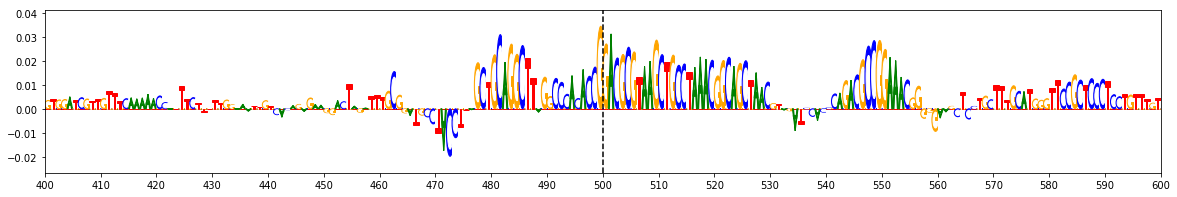

Effect Allele : T   ||   Explain Score : 0.677   ||   Center / 200bp : 0.4574
Effect Sequence : GCCCACACCTGACGCGTAAG


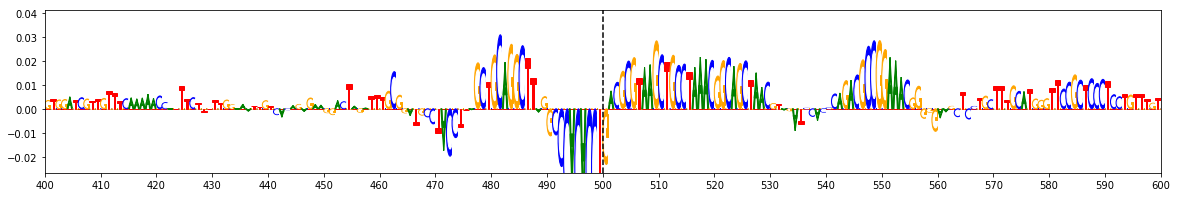

Allele Ratio : 0.7519   ||   Allele Difference : -0.607  ||  ISM Score : -0.9524  ||  deltaSVM Score : -5.5556


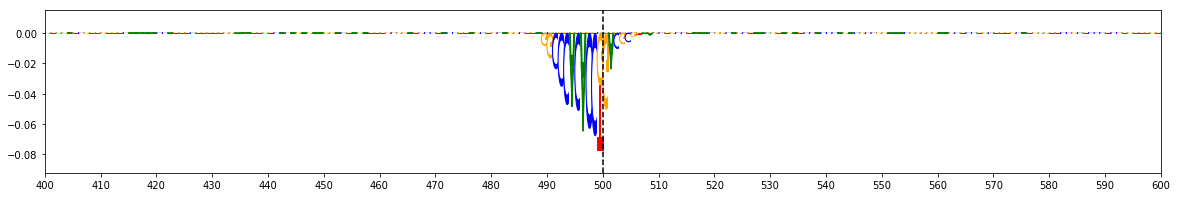


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs17564591   ||    chr17 : 45924695 - 45924696   ||    Locus: 93   ||    IDR Peak: False

GWAS:
23andme_PD_hg38 		  4.03E-22

Coloc:  True

Noneffect Allele : A   ||   Explain Score : 0.8118   ||   Center / 200bp : 0.6041
Noneffect Sequence : ACTTGGAATAGTGGTGACAA


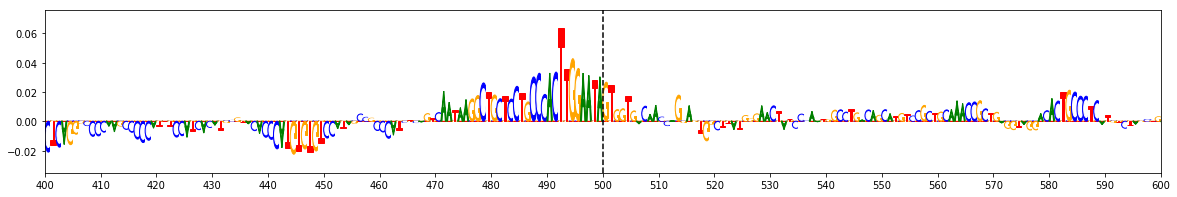

Effect Allele : C   ||   Explain Score : 0.701   ||   Center / 200bp : 0.5682
Effect Sequence : ACTTGGAATCGTGGTGACAA


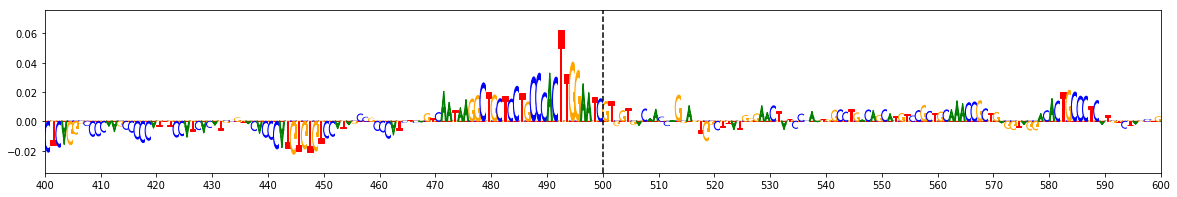

Allele Ratio : 0.8635   ||   Allele Difference : -0.1173  ||  ISM Score : -0.184  ||  deltaSVM Score : -1.0627


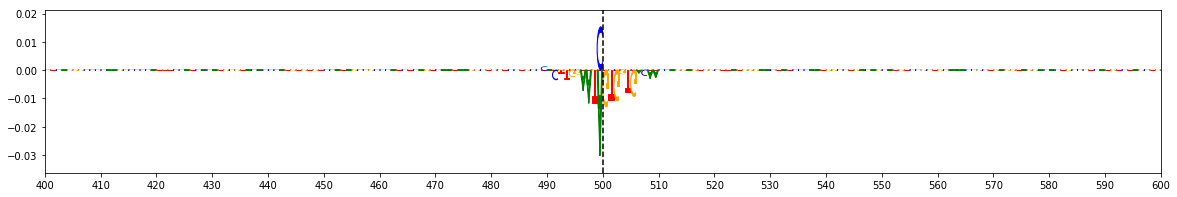


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs11575895   ||    chr17 : 45894418 - 45894419   ||    Locus: 84   ||    IDR Peak: True

GWAS:
23andme_PD_hg38 		  3.94E-22

Coloc:  True

Noneffect Allele : A   ||   Explain Score : 2.5253   ||   Center / 200bp : 0.642
Noneffect Sequence : GCGCCCACTAGTGGCCGGAG


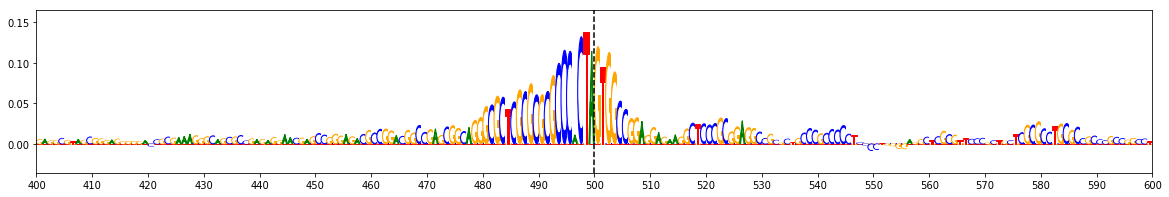

Effect Allele : G   ||   Explain Score : 2.3326   ||   Center / 200bp : 0.6214
Effect Sequence : GCGCCCACTGGTGGCCGGAG


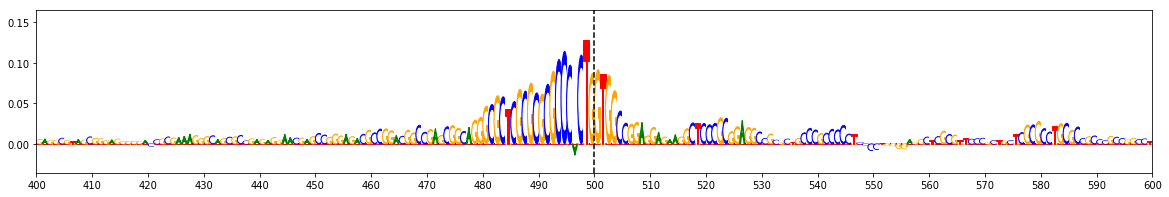

Allele Ratio : 0.9237   ||   Allele Difference : -0.2066  ||  ISM Score : -0.2802  ||  deltaSVM Score : -2.1397


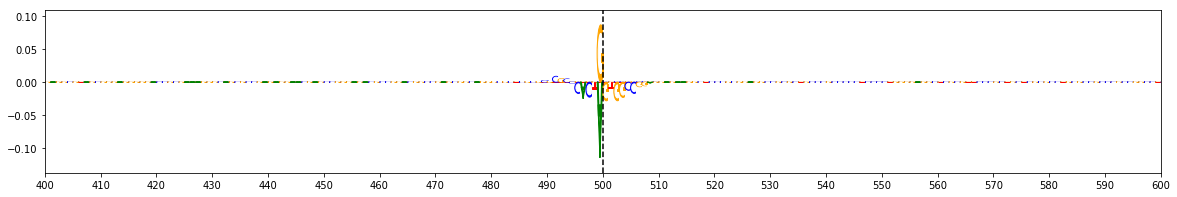


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------




In [6]:
for idx in neg_snps.index[:20]:
    #for idx in [60]:
    print('RSID:', neg_snps.at[idx, 'rsid'],
          '  ||   ', neg_snps.at[idx, 'chr'], ':', neg_snps.at[idx, 'start'], '-', neg_snps.at[idx, 'end'],
          '  ||   ', 'Locus:', idx, '  ||   ', 'IDR Peak:', neg_snps.at[idx, 'idr_peak'])
    
    print()
    
    print('GWAS:')
    
    for i in neg_snps.at[idx, 'all_gwas']:
        entry = i.split(':')
        if 'Lambert' in entry[0] or 'Pankratz' in entry[0] or 'Chang' in entry[0]:
            print(entry[0], '\t', entry[1])
        else:
            print(entry[0], '\t\t', entry[1])
    
    print()
    
    print("Coloc: ", neg_snps.at[idx, 'coloc'])
    
    print()
    
    print('Noneffect Allele :', neg_snps.at[idx, 'noneffect'], '  ||   Explain Score :', round(neg_snps.at[idx, 'noneffect_center'], 4), '  ||   Center / 200bp :', round(neg_snps.at[idx, 'noneffect_ratio'], 4))
    print('Noneffect Sequence :', noneffect_seqs[idx][490:510])
    
    ylim = plot_weights(merged_noneffect_scores[idx], subticks_frequency=10, xlim=(400,600))

    print('Effect Allele :', neg_snps.at[idx, 'effect'], '  ||   Explain Score :', round(neg_snps.at[idx, 'effect_center'], 4), '  ||   Center / 200bp :', round(neg_snps.at[idx, 'effect_ratio'], 4))
    print('Effect Sequence :', effect_seqs[idx][490:510])
    
    a = plot_weights(merged_effect_scores[idx], subticks_frequency=10, ylim=ylim, xlim=(400,600))
    
    print('Allele Ratio :', round(neg_snps.at[idx, 'allele_ratio'], 4), '  ||   Allele Difference :', round(neg_snps.at[idx, 'allele_diff'], 4),
          ' ||  ISM Score :', round(neg_snps.at[idx, 'ism_score'], 4), ' ||  deltaSVM Score :', round(neg_snps.at[idx, 'delta_score'], 4))
    
    a = plot_weights(merged_effect_scores[idx] - merged_noneffect_scores[idx], subticks_frequency=10, xlim=(400,600))
    
    print()
    print('-'*80)
    print('-'*80)
    print()
    print()

## Find Non-Effect Alleles that Improve Accessibility <a name='noneffect_table' />

In [7]:
pos_snps = snps.loc[snps['allele_ratio'] > 1]
pos_snps.sort_values(by=['effect_rank'], ascending=False, inplace=True)
display(pos_snps)

chr      start        end         rsid effect noneffect ref  alt major  \
20   chr11   65834088   65834089   rs17854357      C         G   G  C,T     G   
298   chr8   11845330   11845331    rs1736081      T         G   T    G     T   
268   chr4     987143     987144   rs10902762      G         A   G    A     G   
108  chr17   45973461   45973462    rs9896485      G         C   G    C     G   
304   chr8   22599691   22599692     rs755934      T         G   T    G     T   
212  chr19   45137506   45137507  rs536518226      C         G   G    C     G   
305   chr8   22604860   22604861    rs3735901      T         C   T    C     T   
297   chr7  100494171  100494172   rs12539172      T         C   T  C,G     C   
49   chr16   31106091   31106092    rs2032915      T         C   C    T     C   
3     chr1  171699810  171699811   rs10913511      G         A   G    A     G   
123  chr17   46004160   46004161   rs62064665      T         C   T    C     T   
159  chr19   44644039   44644040   rs11540084      T         G   G    T     G   
68   chr17   45775742   45775743   rs55787105      G         A   G    A     G   
99   chr17   45942313   45942314   rs62062770      T         C   T    C     T   
223   chr2  101762281  101762282    rs2068397      C         A   C    A     C   
24   chr11   86069405   86069406    rs3016327      T         C   T    C     C   
90   chr17   45900753   45900754   rs62056796      G         A   A    G     A   
21   chr11   65889092   65889093    rs2231884      T         C   C    T     C   
221   chr2  101761911  101761912   rs12476714      G         A   A  C,G     A   
121  chr17   46003857   46003858   rs17573509      G         A   G    A     G   
100  chr17   45947185   45947186   rs62062784      G         C   C    G     C   
47   chr16   31074148   31074149    rs2303222      T         C   T  A,C     T   
247   chr3   49119242   49119243    rs4279134      G         A   A    G     G   
217   chr2   95076932   95076933    rs3105101      C         A   C    A     A   
269   chr4   15735724   15735725    rs4698412      G         A   G  A,T     G   
301   chr8   11845910   11845911    rs1736082      T         C   C    T     C   
31   chr14   67515152   67515153    rs2273596      T         C   T    C     T   
10   chr10  102245652  102245653    rs2296887      T         C   T    C     T   
291   chr7   23205949   23205950     rs858295      G         A   A  C,G     A   
233   chr2  127107345  127107346   rs78710909    NAN       NAN   G    C     G   
..     ...        ...        ...          ...    ...       ...  ..  ...   ...   
5     chr1  205750403  205750404     rs823114      G         A   G    A     G   
81   chr17   45894090   45894091   rs76594404      G         C   G  A,C     G   
292   chr7   23222815   23222816    rs1624451      T         A   T    A     T   
249   chr3   52218979   52218980   rs74735459      G         C   C    G     C   
189  chr19   44915228   44915229   rs12691088      A         G   G  A,C     G   
267   chr4     987107     987108   rs11248061      C         A   C    A     C   
109  chr17   45973483   45973484   rs62063776      G         A   A    G     A   
145  chr17   78432504   78432505  17_78432505      G         A   .    .     .   
124  chr17   46091141   46091142  rs111364350      T         C   C    T     C   
104  chr17   45949123   45949124   rs77266933      C         A   A    C     A   
234   chr2  127107523  127107524   rs13032148      A         G   G    A     G   
52   chr16   31142824   31142825    rs1549299    NAN       NAN   G    A     A   
265   chr4     973656     973657   rs13137144      G         A   G  A,C     G   
130  chr17   46192597   46192598   rs11079733      T         A   T    A     T   
168  chr19   44784591   44784592    rs2927448      T         G   G    T     G   
188  chr19   44913220   44913221     rs584007      A         G   A    G     G   
13   chr11   47341663   47341664    rs2697923      T         G   G  A,T     T   
254   chr3   52420251   52420252  rs15

## Visualize Top Non-Effect Alleles <a name='noneffect_viz' />

RSID: rs17854357   ||    chr11 : 65834088 - 65834089   ||    Locus: 20   ||    IDR Peak: True

GWAS:
Alzheimers_Jansen_2018 		  3.26E-06

Coloc:  True

Effect Allele: C   ||  Explain Score: 0.404   ||  Center / 200bp: 0.4277
Effect Sequence: GGAGGTTGGCAAGGAGGGCA


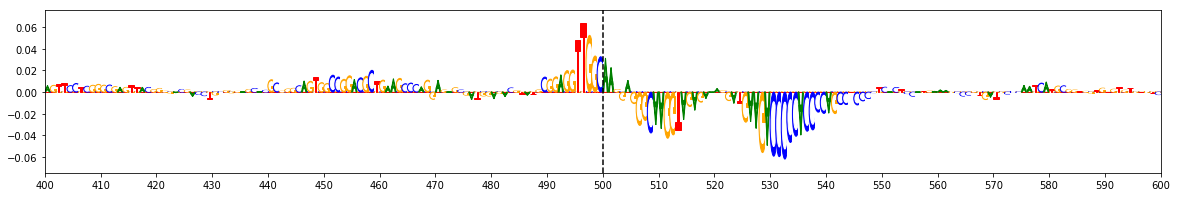

Noneffect Allele: G   ||  Explain Score: 0.119   ||  Center / 200bp: 0.1803
Noneffect Sequence: GGAGGTTGGGAAGGAGGGCA


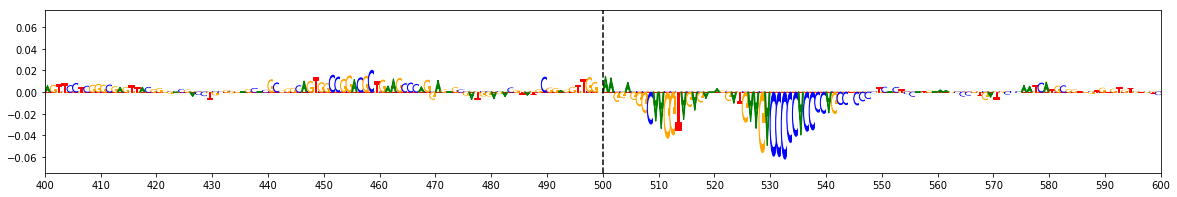

Allele Ratio : 3.3957   ||   Allele Difference : 0.2508  ||  ISM Score : 0.4239  ||  deltaSVM Score : 2.443


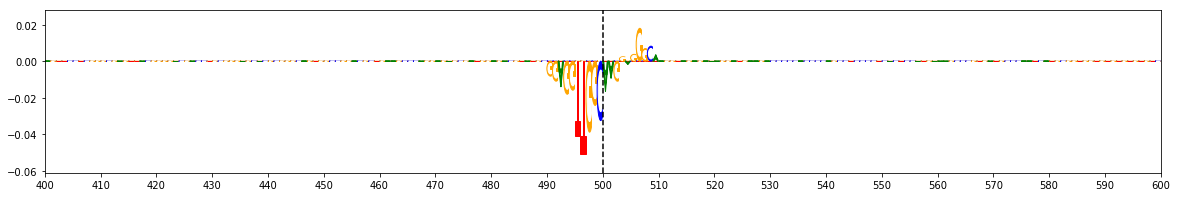


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs1736081   ||    chr8 : 11845330 - 11845331   ||    Locus: 298   ||    IDR Peak: True

GWAS:
Chang_23andMe_Parkinsons 	  1.11E-04

Coloc:  False

Effect Allele: T   ||  Explain Score: 0.4902   ||  Center / 200bp: 0.5117
Effect Sequence: TCCTGCTGTTGGCCCACTAG


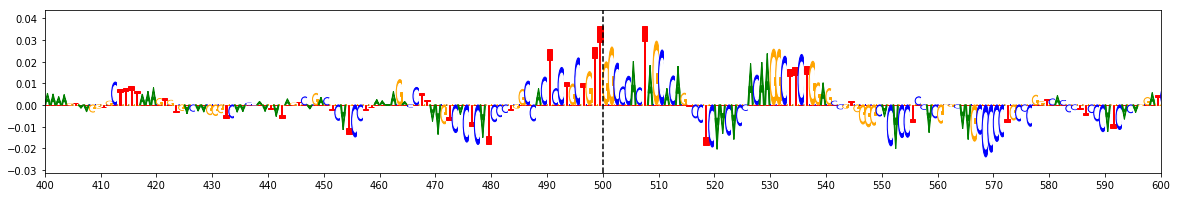

Noneffect Allele: G   ||  Explain Score: 0.2012   ||  Center / 200bp: 0.3019
Noneffect Sequence: TCCTGCTGTGGGCCCACTAG


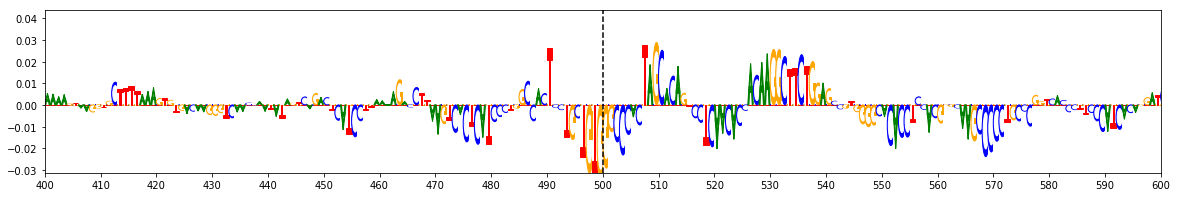

Allele Ratio : 2.4363   ||   Allele Difference : 0.5615  ||  ISM Score : 0.8752  ||  deltaSVM Score : 5.0489


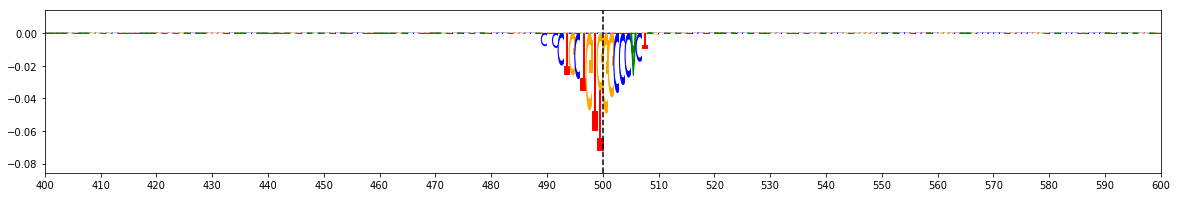


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs10902762   ||    chr4 : 987143 - 987144   ||    Locus: 268   ||    IDR Peak: True

GWAS:
23andme_PD_hg38 		  3.90E-11

Coloc:  True

Effect Allele: G   ||  Explain Score: 0.5549   ||  Center / 200bp: 0.5397
Effect Sequence: CCTGGCCGCGCCCCCGGTGG


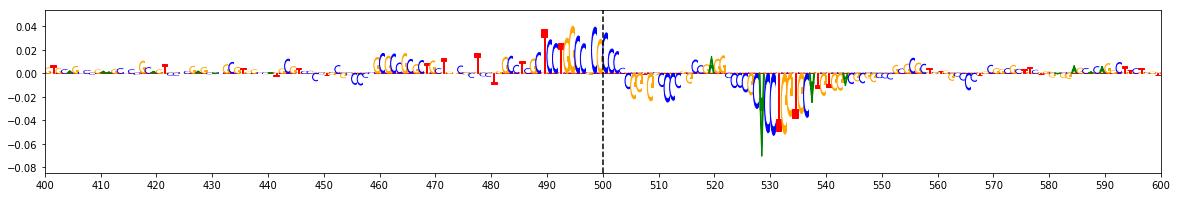

Noneffect Allele: A   ||  Explain Score: 0.3025   ||  Center / 200bp: 0.3862
Noneffect Sequence: CCTGGCCGCACCCCCGGTGG


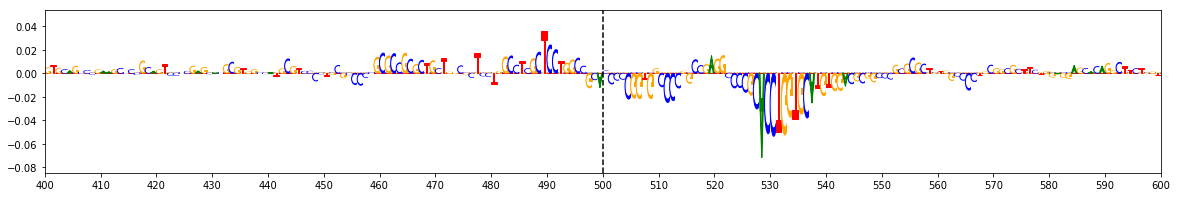

Allele Ratio : 1.8346   ||   Allele Difference : 0.3189  ||  ISM Score : 0.5163  ||  deltaSVM Score : 3.1477


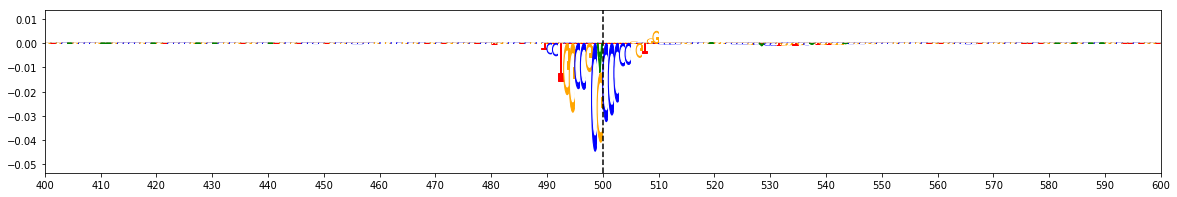


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs9896485   ||    chr17 : 45973461 - 45973462   ||    Locus: 108   ||    IDR Peak: False

GWAS:
23andme_PD_hg38 		  7.79E-09

Coloc:  True

Effect Allele: G   ||  Explain Score: 0.7011   ||  Center / 200bp: 0.3185
Effect Sequence: AGTCGCAATGCCCTCTGGAC


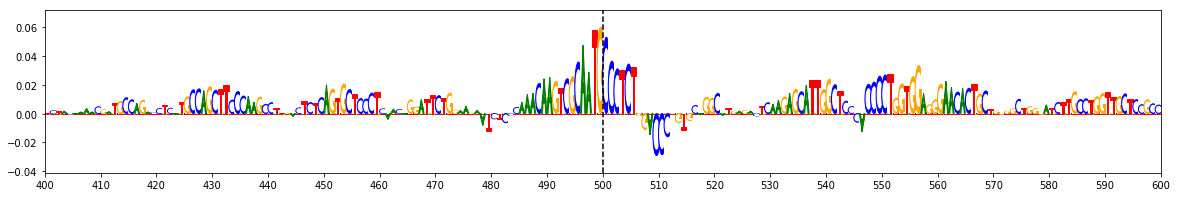

Noneffect Allele: C   ||  Explain Score: 0.2507   ||  Center / 200bp: 0.1431
Noneffect Sequence: AGTCGCAATCCCCTCTGGAC


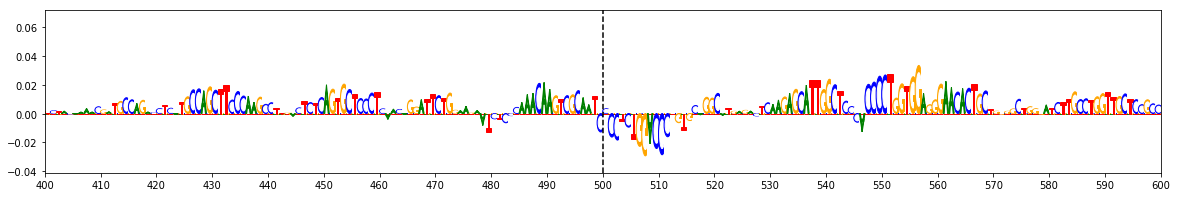

Allele Ratio : 2.796   ||   Allele Difference : 0.5713  ||  ISM Score : 0.8972  ||  deltaSVM Score : 5.1449


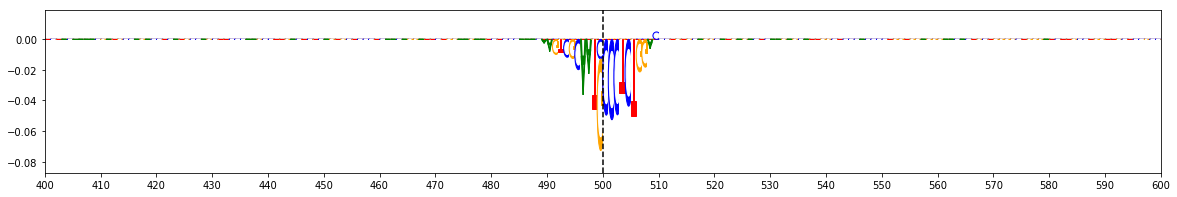


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs755934   ||    chr8 : 22599691 - 22599692   ||    Locus: 304   ||    IDR Peak: True

GWAS:
Chang_23andMe_Parkinsons 	  5.11E-02
Nalls_23andMe 		  5.11E-02

Coloc:  False

Effect Allele: T   ||  Explain Score: 0.8916   ||  Center / 200bp: 0.5783
Effect Sequence: GCGGCTGCATTGGCCGGGGC


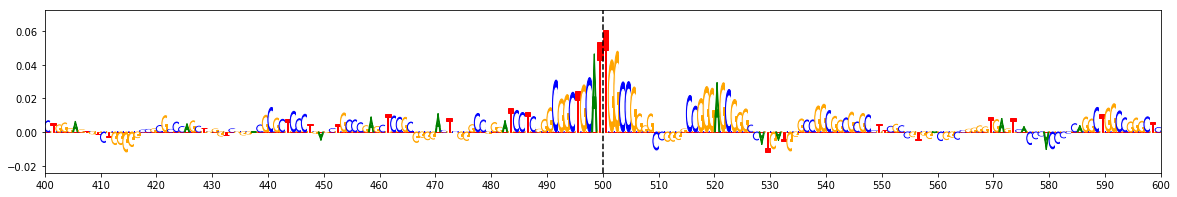

Noneffect Allele: G   ||  Explain Score: 0.6322   ||  Center / 200bp: 0.4945
Noneffect Sequence: GCGGCTGCAGTGGCCGGGGC


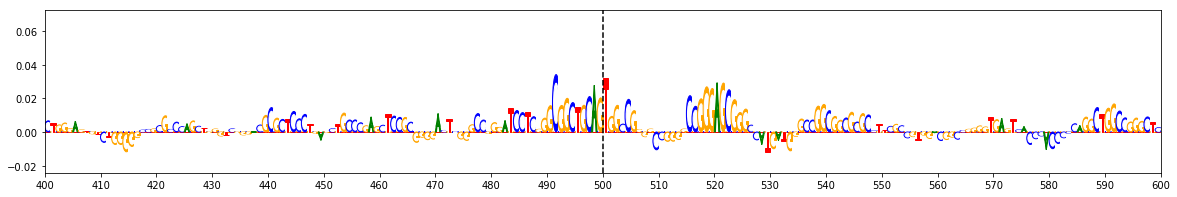

Allele Ratio : 1.4102   ||   Allele Difference : 0.2619  ||  ISM Score : 0.4197  ||  deltaSVM Score : 2.5762


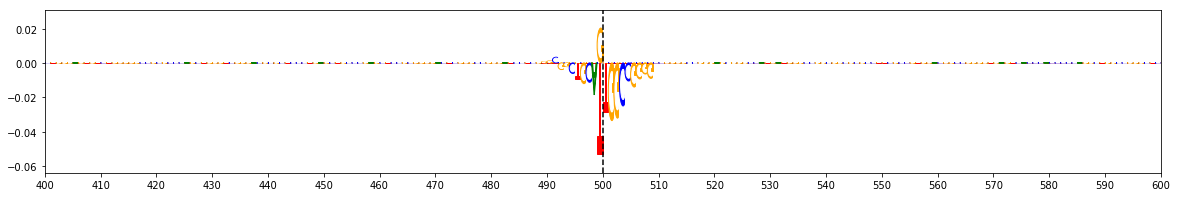


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs536518226   ||    chr19 : 45137506 - 45137507   ||    Locus: 212   ||    IDR Peak: True

GWAS:
Alzheimers_Jansen_2018 		  1.88E-19

Coloc:  True

Effect Allele: C   ||  Explain Score: 0.5514   ||  Center / 200bp: 0.3204
Effect Sequence: AGCTGTTGGCTTTGGGCTAC


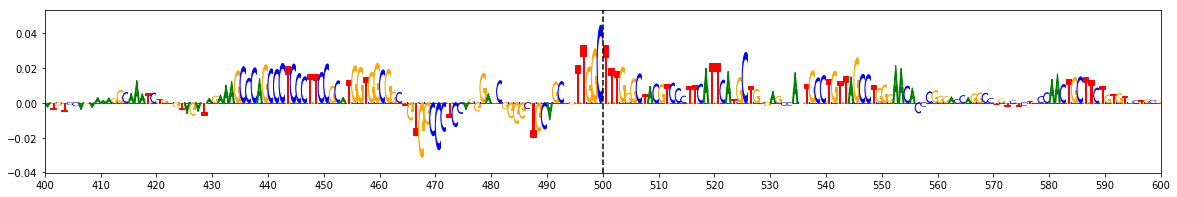

Noneffect Allele: G   ||  Explain Score: 0.2373   ||  Center / 200bp: 0.1685
Noneffect Sequence: AGCTGTTGGGTTTGGGCTAC


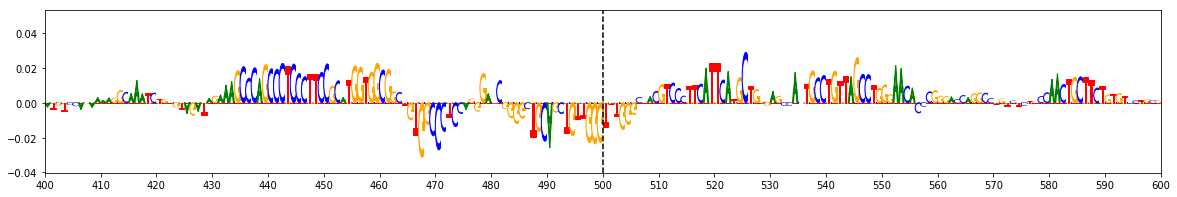

Allele Ratio : 2.3235   ||   Allele Difference : 0.529  ||  ISM Score : 0.827  ||  deltaSVM Score : 4.781


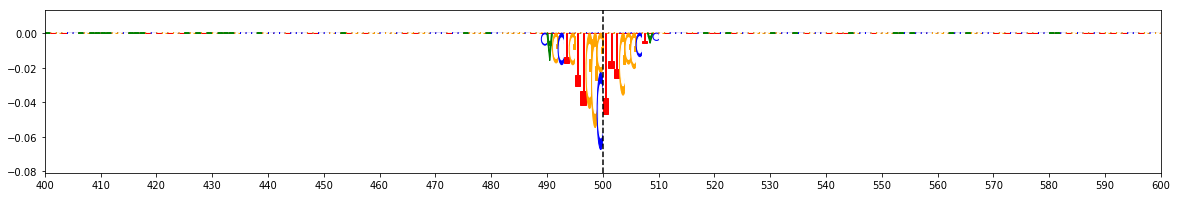


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs3735901   ||    chr8 : 22604860 - 22604861   ||    Locus: 305   ||    IDR Peak: True

GWAS:
Chang_23andMe_Parkinsons 	  5.08E-02
Nalls_23andMe 		  5.08E-02

Coloc:  False

Effect Allele: T   ||  Explain Score: 0.2652   ||  Center / 200bp: 0.1861
Effect Sequence: GGGGCCCCCTGCCGCCCCTC


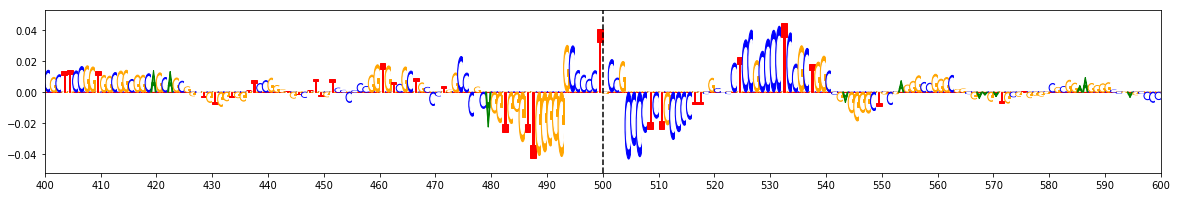

Noneffect Allele: C   ||  Explain Score: 0.0665   ||  Center / 200bp: 0.0558
Noneffect Sequence: GGGGCCCCCCGCCGCCCCTC


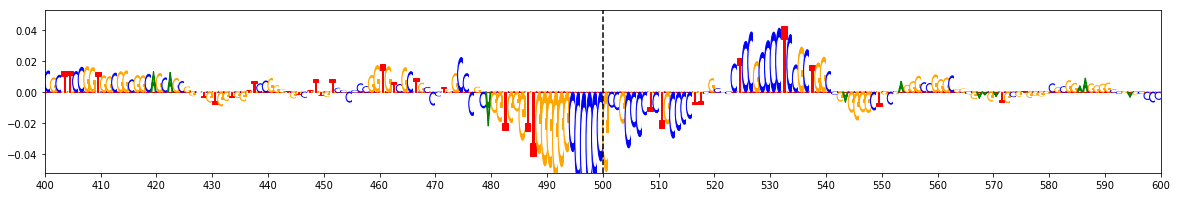

Allele Ratio : 3.988   ||   Allele Difference : 0.6396  ||  ISM Score : 1.0053  ||  deltaSVM Score : 6.5507


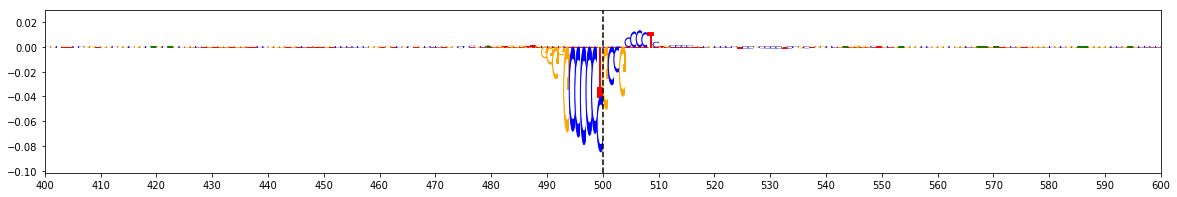


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs12539172   ||    chr7 : 100494171 - 100494172   ||    Locus: 297   ||    IDR Peak: True

GWAS:
Alzheimers_Jansen_2018 		  6.95E-13

Coloc:  True

Effect Allele: T   ||  Explain Score: 1.1998   ||  Center / 200bp: 0.5177
Effect Sequence: CGCTGGGCGTTGTACACCCC


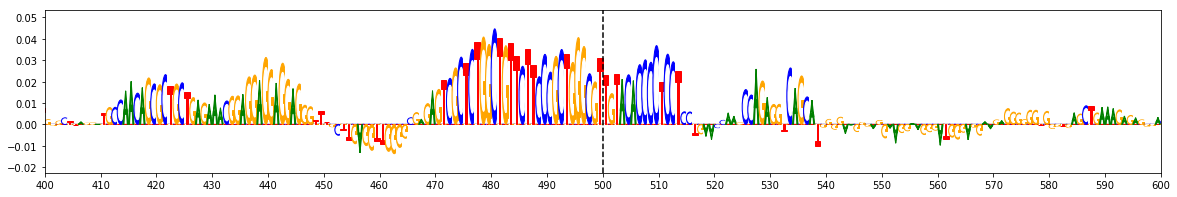

Noneffect Allele: C   ||  Explain Score: 0.8567   ||  Center / 200bp: 0.4338
Noneffect Sequence: CGCTGGGCGCTGTACACCCC


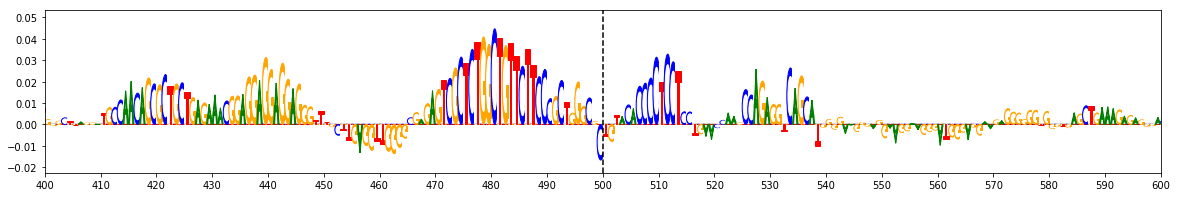

Allele Ratio : 1.4005   ||   Allele Difference : 0.3732  ||  ISM Score : 0.6009  ||  deltaSVM Score : 3.5159


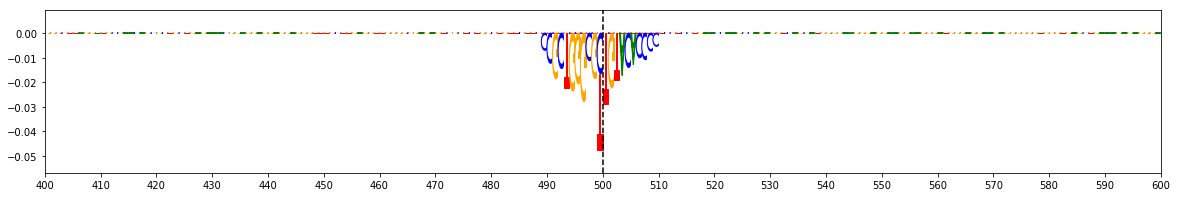


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs2032915   ||    chr16 : 31106091 - 31106092   ||    Locus: 49   ||    IDR Peak: True

GWAS:
Chang_23andMe_Parkinsons 	  3.22E-02

Coloc:  False

Effect Allele: T   ||  Explain Score: 0.9952   ||  Center / 200bp: 0.5719
Effect Sequence: CTGGCTGTATTCCAGGACGT


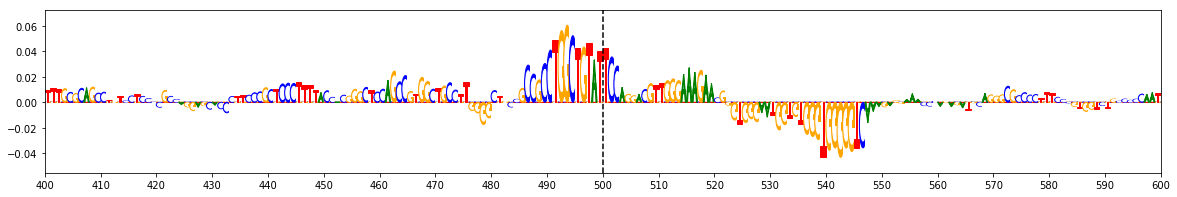

Noneffect Allele: C   ||  Explain Score: 0.7949   ||  Center / 200bp: 0.5164
Noneffect Sequence: CTGGCTGTACTCCAGGACGT


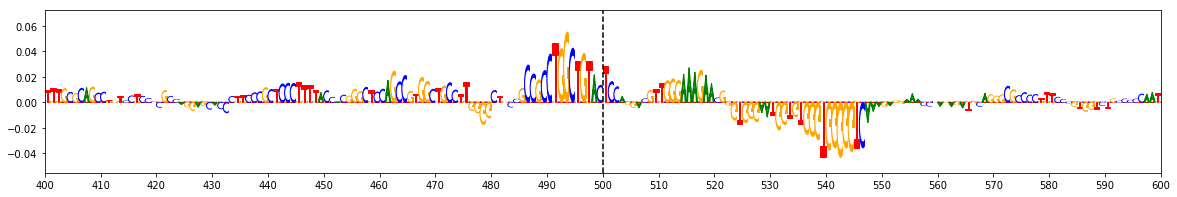

Allele Ratio : 1.252   ||   Allele Difference : 0.2102  ||  ISM Score : 0.3306  ||  deltaSVM Score : 1.9291


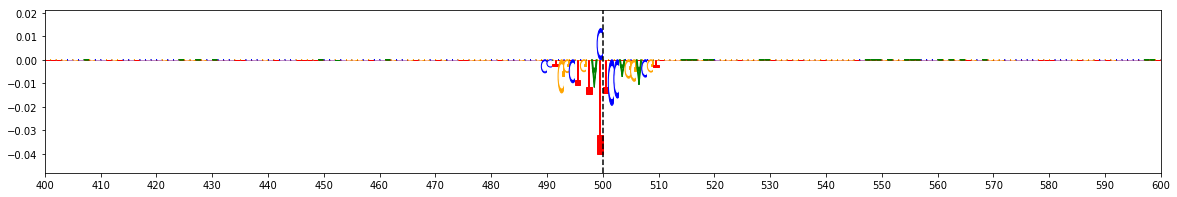


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs10913511   ||    chr1 : 171699810 - 171699811   ||    Locus: 3   ||    IDR Peak: False

GWAS:
Nalls_23andMe 		  6.51E-02

Coloc:  False

Effect Allele: G   ||  Explain Score: 0.8854   ||  Center / 200bp: 0.471
Effect Sequence: ACTCTGGTTGCCTAAAGCAC


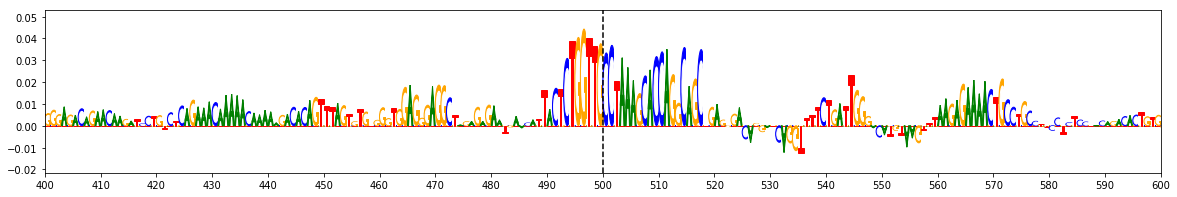

Noneffect Allele: A   ||  Explain Score: 0.5879   ||  Center / 200bp: 0.3715
Noneffect Sequence: ACTCTGGTTACCTAAAGCAC


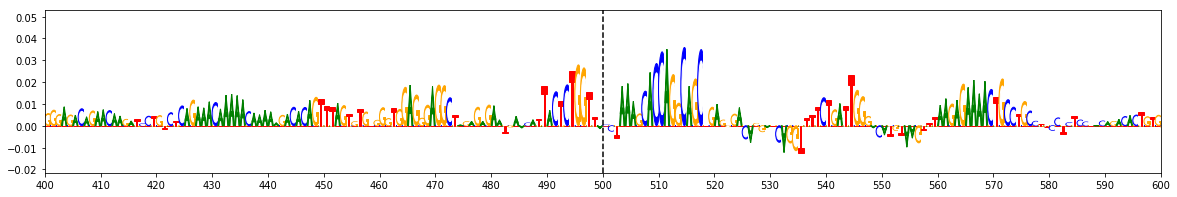

Allele Ratio : 1.5061   ||   Allele Difference : 0.3069  ||  ISM Score : 0.4806  ||  deltaSVM Score : 2.7572


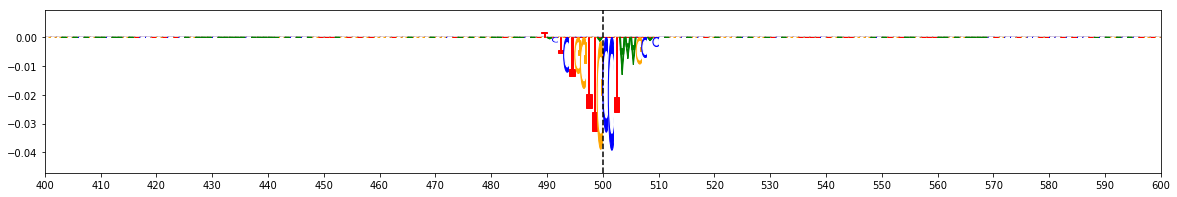


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs62064665   ||    chr17 : 46004160 - 46004161   ||    Locus: 123   ||    IDR Peak: True

GWAS:
23andme_PD_hg38 		  2.11E-22

Coloc:  True

Effect Allele: T   ||  Explain Score: 2.0227   ||  Center / 200bp: 0.6093
Effect Sequence: CAGGCCAAGTCTGGGCCAGC


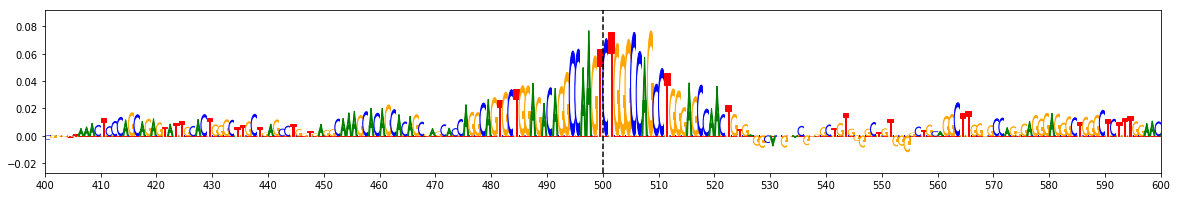

Noneffect Allele: C   ||  Explain Score: 1.7381   ||  Center / 200bp: 0.5738
Noneffect Sequence: CAGGCCAAGCCTGGGCCAGC


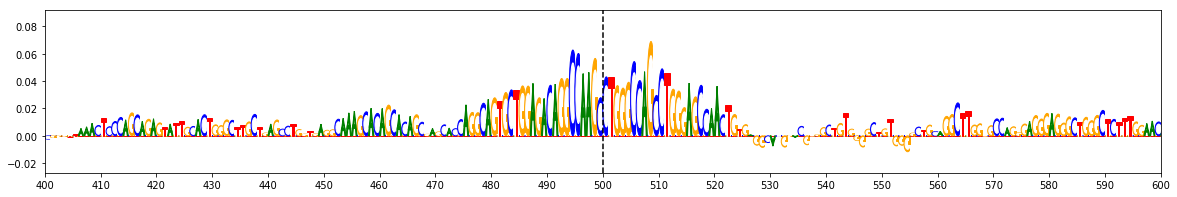

Allele Ratio : 1.1638   ||   Allele Difference : 0.2846  ||  ISM Score : 0.4601  ||  deltaSVM Score : 2.5268


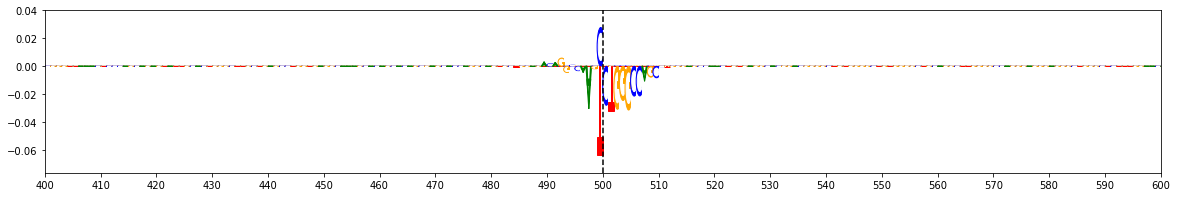


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs11540084   ||    chr19 : 44644039 - 44644040   ||    Locus: 159   ||    IDR Peak: True

GWAS:
Alzheimers_Kunkle_2019 		  5.12E-08
Alzheimers_Jansen_2018 		  2.18E-08

Coloc:  True

Effect Allele: T   ||  Explain Score: 1.1557   ||  Center / 200bp: 0.541
Effect Sequence: AGAGCGAGCTGGCGCCGGGA


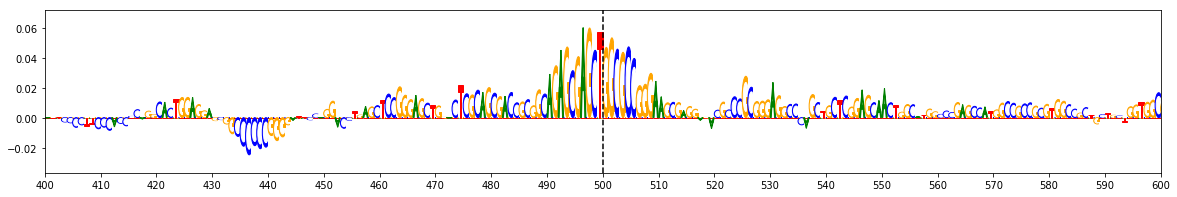

Noneffect Allele: G   ||  Explain Score: 0.8946   ||  Center / 200bp: 0.4776
Noneffect Sequence: AGAGCGAGCGGGCGCCGGGA


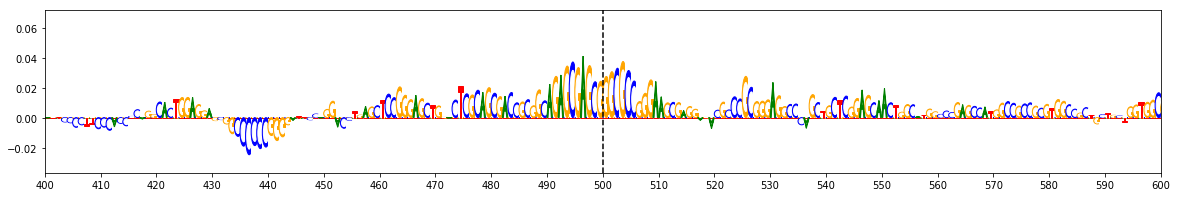

Allele Ratio : 1.2919   ||   Allele Difference : 0.2611  ||  ISM Score : 0.4126  ||  deltaSVM Score : 2.393


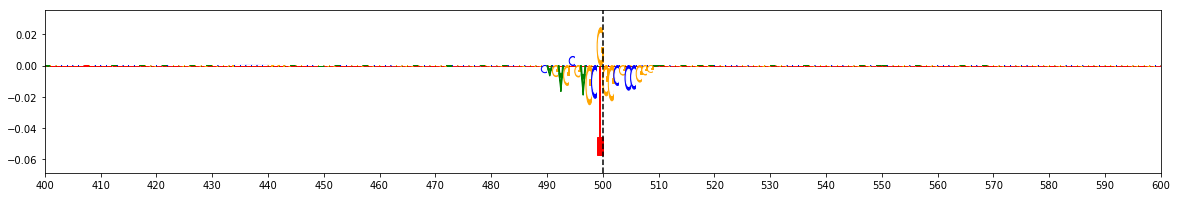


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs55787105   ||    chr17 : 45775742 - 45775743   ||    Locus: 68   ||    IDR Peak: False

GWAS:
23andme_PD_hg38 		  2.62E-22

Coloc:  True

Effect Allele: G   ||  Explain Score: 1.935   ||  Center / 200bp: 0.6773
Effect Sequence: GCTGGCTCTGAGCCACAGGC


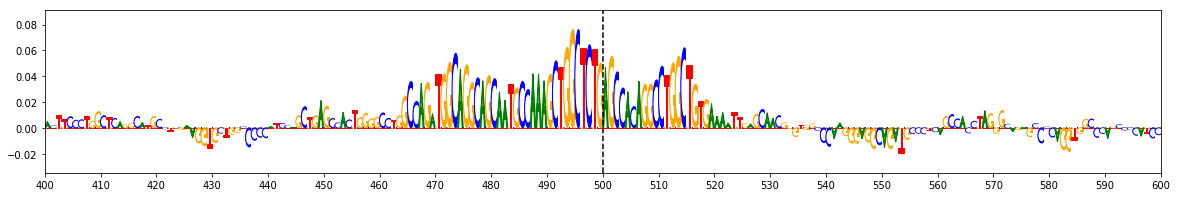

Noneffect Allele: A   ||  Explain Score: 1.8829   ||  Center / 200bp: 0.6679
Noneffect Sequence: GCTGGCTCTAAGCCACAGGC


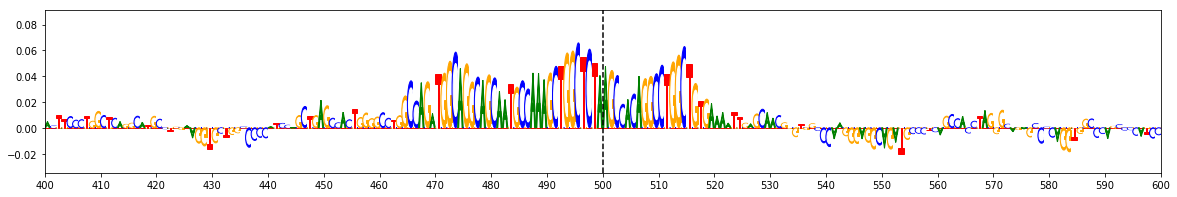

Allele Ratio : 1.0276   ||   Allele Difference : 0.052  ||  ISM Score : 0.0811  ||  deltaSVM Score : 0.5538


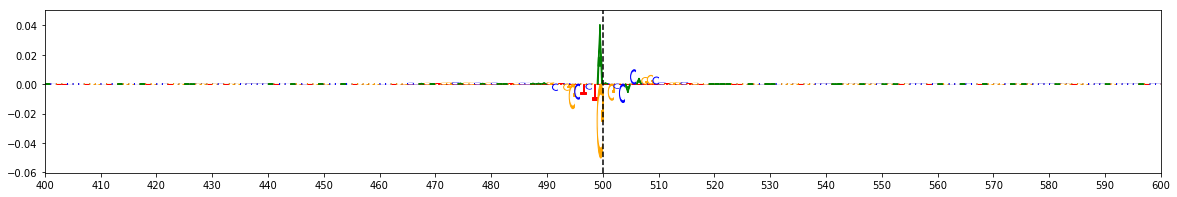


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs62062770   ||    chr17 : 45942313 - 45942314   ||    Locus: 99   ||    IDR Peak: True

GWAS:
23andme_PD_hg38 		  3.67E-22

Coloc:  True

Effect Allele: T   ||  Explain Score: 0.8595   ||  Center / 200bp: 0.5749
Effect Sequence: CGTTTCTTCTTCCTTACAAA


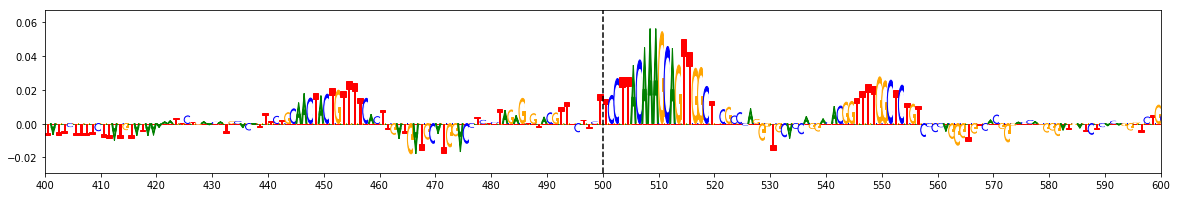

Noneffect Allele: C   ||  Explain Score: 0.7499   ||  Center / 200bp: 0.5413
Noneffect Sequence: CGTTTCTTCCTCCTTACAAA


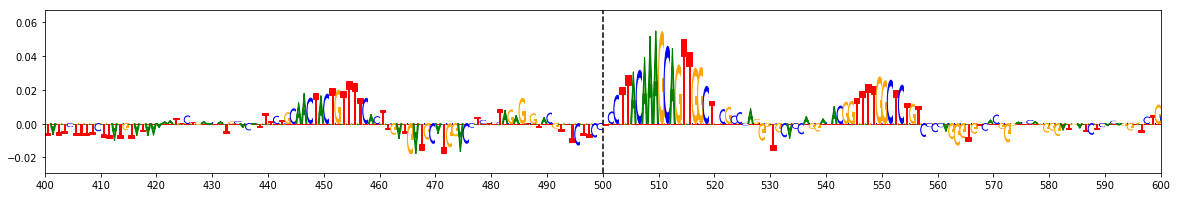

Allele Ratio : 1.1461   ||   Allele Difference : 0.1601  ||  ISM Score : 0.2495  ||  deltaSVM Score : 1.4728


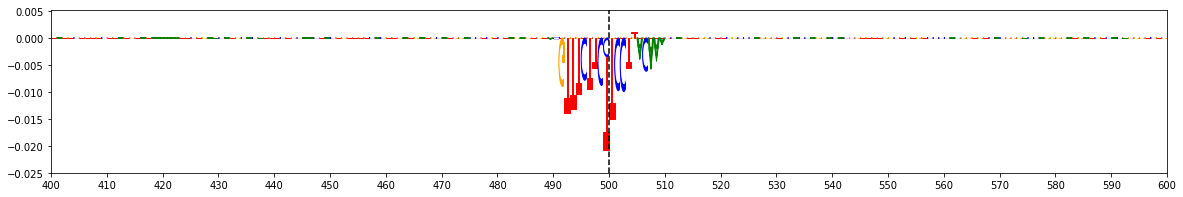


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs2068397   ||    chr2 : 101762281 - 101762282   ||    Locus: 223   ||    IDR Peak: True

GWAS:
Chang_23andMe_Parkinsons 	  1.14E-03
Nalls_23andMe 		  1.14E-03

Coloc:  False

Effect Allele: C   ||  Explain Score: 0.6088   ||  Center / 200bp: 0.3897
Effect Sequence: GGCAAATTGCCACACCTAGG


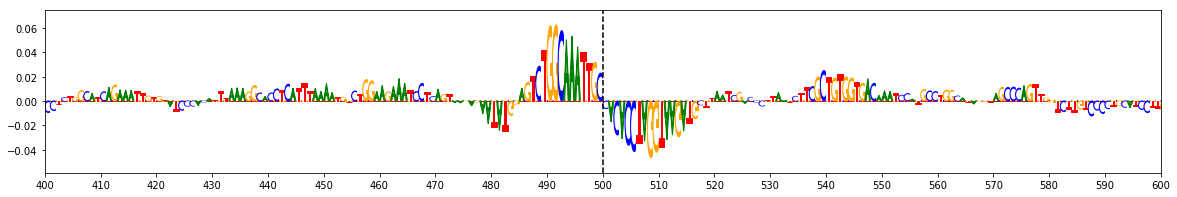

Noneffect Allele: A   ||  Explain Score: 0.3635   ||  Center / 200bp: 0.2747
Noneffect Sequence: GGCAAATTGACACACCTAGG


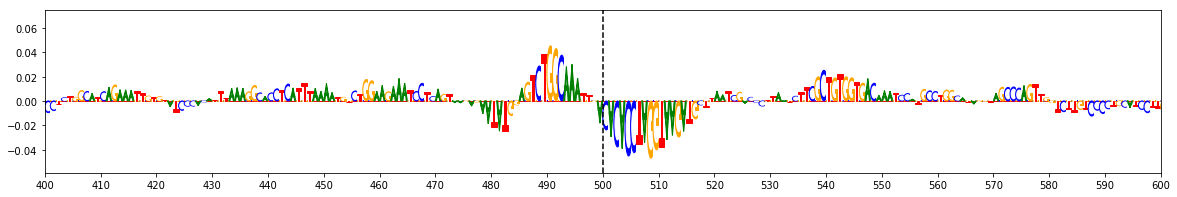

Allele Ratio : 1.6747   ||   Allele Difference : 0.3241  ||  ISM Score : 0.5055  ||  deltaSVM Score : 2.8202


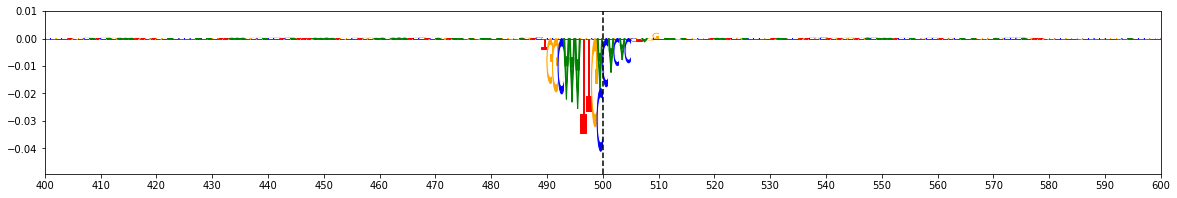


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs3016327   ||    chr11 : 86069405 - 86069406   ||    Locus: 24   ||    IDR Peak: True

GWAS:
Alzheimers_Jansen_2018 		  1.41E-11

Coloc:  False

Effect Allele: T   ||  Explain Score: 1.2633   ||  Center / 200bp: 0.4931
Effect Sequence: CGAGGGCGGTGTGCTGGCGG


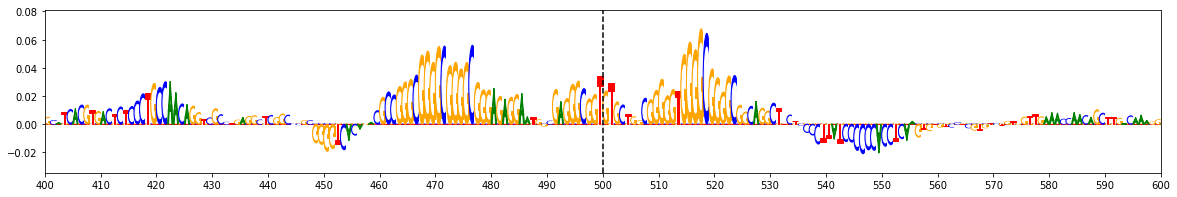

Noneffect Allele: C   ||  Explain Score: 0.9611   ||  Center / 200bp: 0.4257
Noneffect Sequence: CGAGGGCGGCGTGCTGGCGG


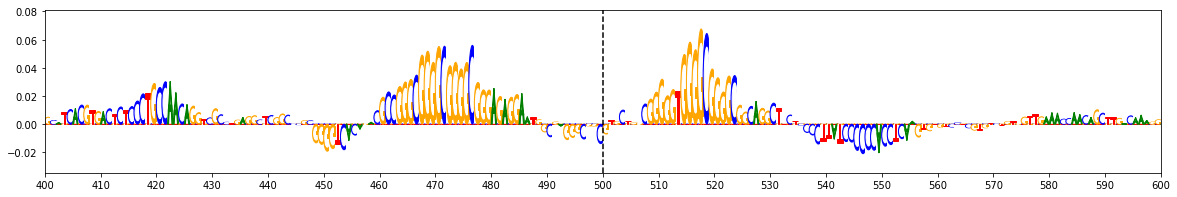

Allele Ratio : 1.3144   ||   Allele Difference : 0.3772  ||  ISM Score : 0.6278  ||  deltaSVM Score : 3.7219


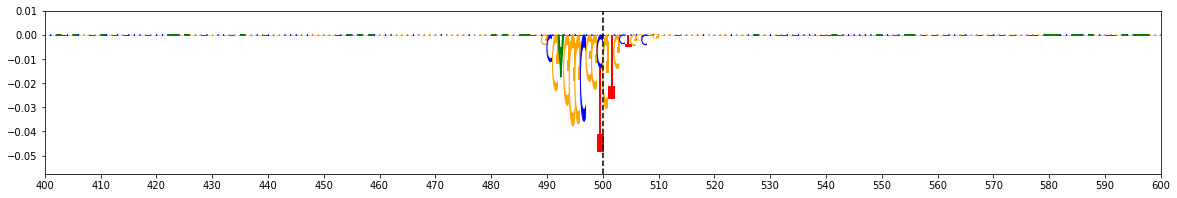


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs62056796   ||    chr17 : 45900753 - 45900754   ||    Locus: 90   ||    IDR Peak: False

GWAS:
23andme_PD_hg38 		  3.94E-22

Coloc:  True

Effect Allele: G   ||  Explain Score: 1.2337   ||  Center / 200bp: 0.5963
Effect Sequence: TGGGCACAAGTCCCAGCTCC


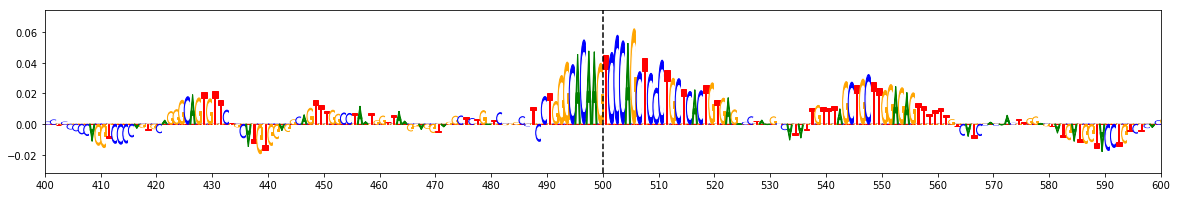

Noneffect Allele: A   ||  Explain Score: 1.1441   ||  Center / 200bp: 0.5782
Noneffect Sequence: TGGGCACAAATCCCAGCTCC


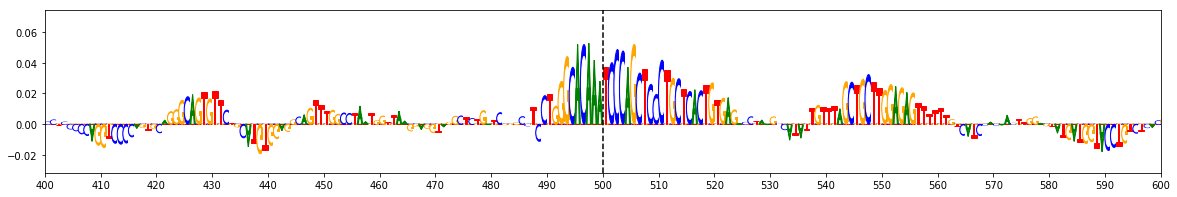

Allele Ratio : 1.0783   ||   Allele Difference : 0.0896  ||  ISM Score : 0.1382  ||  deltaSVM Score : 0.8038


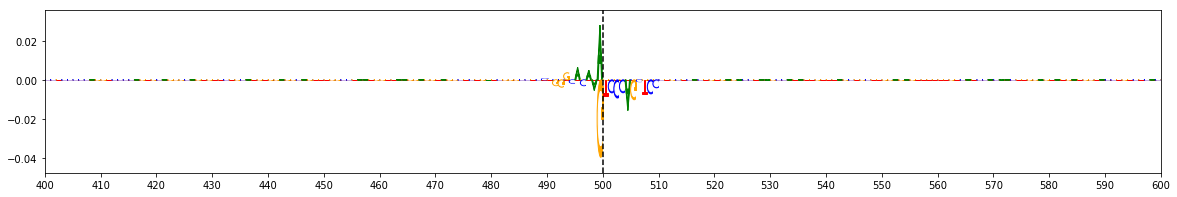


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs2231884   ||    chr11 : 65889092 - 65889093   ||    Locus: 21   ||    IDR Peak: False

GWAS:
Alzheimers_Jansen_2018 		  2.37E-06

Coloc:  True

Effect Allele: T   ||  Explain Score: 0.4803   ||  Center / 200bp: 0.354
Effect Sequence: CGTAAGCCCTTCAAAAGCTC


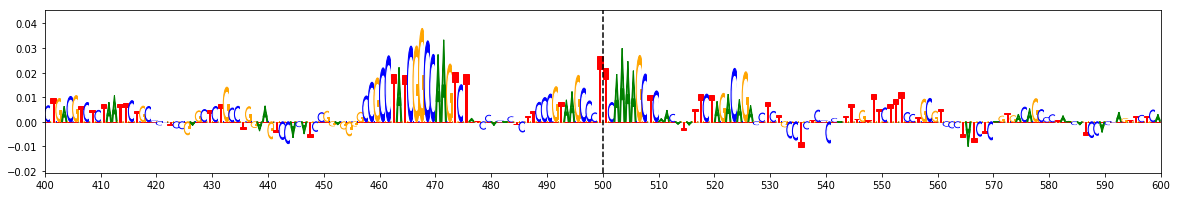

Noneffect Allele: C   ||  Explain Score: 0.2652   ||  Center / 200bp: 0.2323
Noneffect Sequence: CGTAAGCCCCTCAAAAGCTC


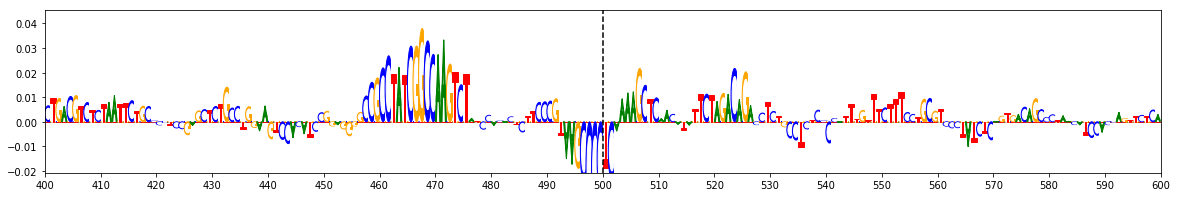

Allele Ratio : 1.811   ||   Allele Difference : 0.4482  ||  ISM Score : 0.701  ||  deltaSVM Score : 4.0357


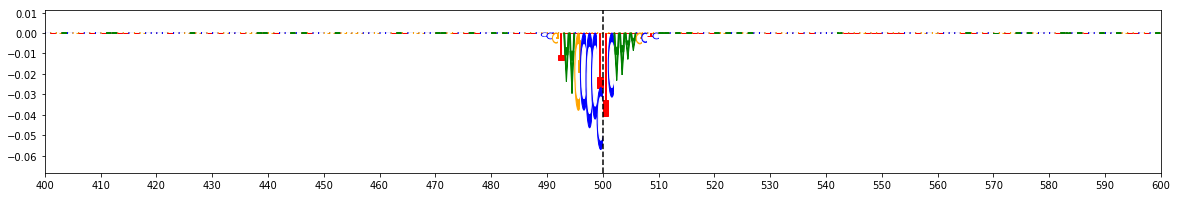


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs12476714   ||    chr2 : 101761911 - 101761912   ||    Locus: 221   ||    IDR Peak: True

GWAS:
Nalls_23andMe 		  1.50E-03
Chang_23andMe_Parkinsons 	  1.50E-03

Coloc:  False

Effect Allele: G   ||  Explain Score: 0.9411   ||  Center / 200bp: 0.5738
Effect Sequence: CACCGAGCTGCATTCAGCGC


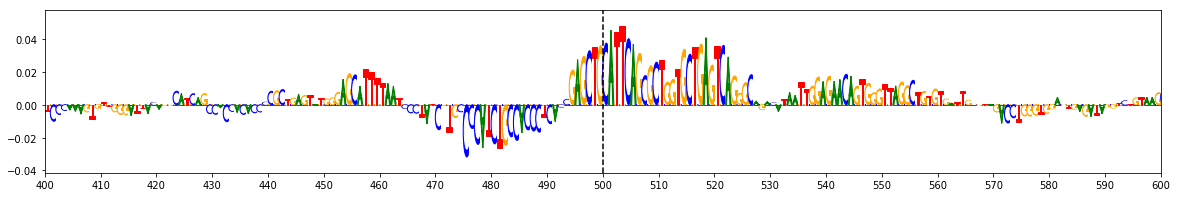

Noneffect Allele: A   ||  Explain Score: 0.8608   ||  Center / 200bp: 0.5516
Noneffect Sequence: CACCGAGCTACATTCAGCGC


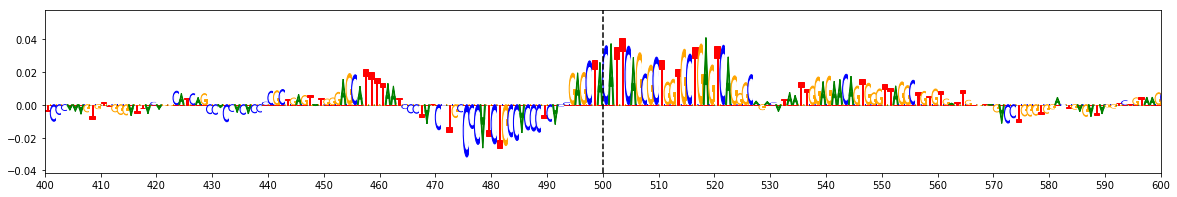

Allele Ratio : 1.0932   ||   Allele Difference : 0.0807  ||  ISM Score : 0.1245  ||  deltaSVM Score : 0.7129


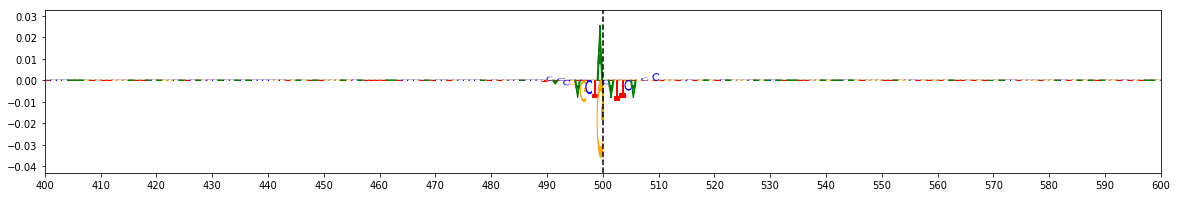


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs17573509   ||    chr17 : 46003857 - 46003858   ||    Locus: 121   ||    IDR Peak: True

GWAS:
23andme_PD_hg38 		  2.14E-22

Coloc:  True

Effect Allele: G   ||  Explain Score: 0.7671   ||  Center / 200bp: 0.5914
Effect Sequence: AATCTGTGTGAATCAAATCA


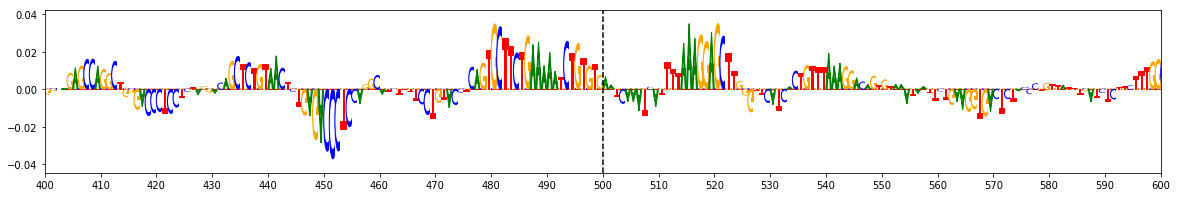

Noneffect Allele: A   ||  Explain Score: 0.7274   ||  Center / 200bp: 0.5792
Noneffect Sequence: AATCTGTGTAAATCAAATCA


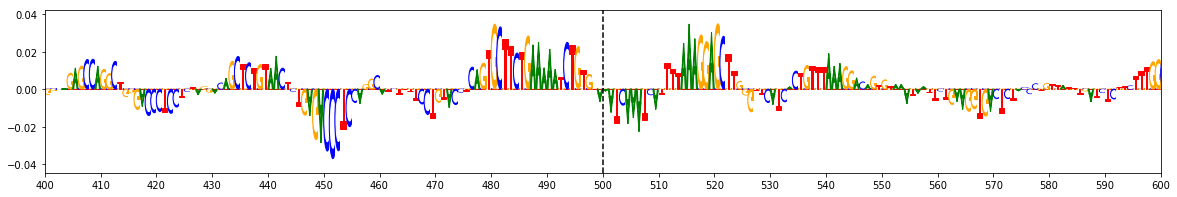

Allele Ratio : 1.0545   ||   Allele Difference : 0.1134  ||  ISM Score : 0.1748  ||  deltaSVM Score : 0.9944


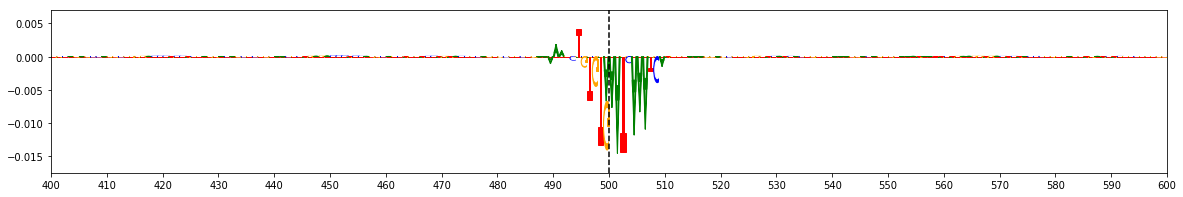


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------




In [8]:
for idx in pos_snps.index[:20]:
    #for idx in [60]:
    print('RSID:', pos_snps.at[idx, 'rsid'],
          '  ||   ', pos_snps.at[idx, 'chr'], ':', pos_snps.at[idx, 'start'], '-', pos_snps.at[idx, 'end'],
          '  ||   ', 'Locus:', idx, '  ||   ', 'IDR Peak:', pos_snps.at[idx, 'idr_peak'])
    
    print()
    
    print('GWAS:')
    
    for i in pos_snps.at[idx, 'all_gwas']:
        entry = i.split(':')
        if 'Lambert' in entry[0] or 'Pankratz' in entry[0] or 'Chang' in entry[0]:
            print(entry[0], '\t', entry[1])
        else:
            print(entry[0], '\t\t', entry[1])
    
    print()
        
    print("Coloc: ", pos_snps.at[idx, 'coloc'])
    
    print()
    
    print('Effect Allele:', pos_snps.at[idx, 'effect'], '  ||  Explain Score:', round(pos_snps.at[idx, 'effect_center'], 4), '  ||  Center / 200bp:', round(pos_snps.at[idx, 'effect_ratio'], 4))
    print('Effect Sequence:', effect_seqs[idx][490:510])
    
    ylim = plot_weights(merged_effect_scores[idx], subticks_frequency=10, xlim=(400,600))

    print('Noneffect Allele:', pos_snps.at[idx, 'noneffect'], '  ||  Explain Score:', round(pos_snps.at[idx, 'noneffect_center'], 4), '  ||  Center / 200bp:', round(pos_snps.at[idx, 'noneffect_ratio'], 4))
    print('Noneffect Sequence:', noneffect_seqs[idx][490:510])
    
    a = plot_weights(merged_noneffect_scores[idx], subticks_frequency=10, ylim=ylim, xlim=(400,600))
    
    print('Allele Ratio :', round(pos_snps.at[idx, 'allele_ratio'], 4), '  ||   Allele Difference :', round(pos_snps.at[idx, 'allele_diff'], 4),
          ' ||  ISM Score :', round(pos_snps.at[idx, 'ism_score'], 4), ' ||  deltaSVM Score :', round(pos_snps.at[idx, 'delta_score'], 4))
    
    a = plot_weights(merged_noneffect_scores[idx] - merged_effect_scores[idx], subticks_frequency=10, xlim=(400,600))
    
    print()
    print('-'*80)
    print('-'*80)
    print()
    print()